Date: 2025.02.09  
I already change the action count into actual action count before analyzing the results and visualization.

Date: 2025.02.07  
This file is to test different model tuning strategies by changing the NN structure, Batch size, pac, epocs, etc.  
Finally, using the defaulted parameters and changing the epochs to 2000 will give a relatively better metrics.  
Therefore, I will use thsi file to refine the data visulizations

Date: 2025.02.04  
This file is based on the 29 file.  
1) I revised the rogue-N metric from rogue-precise to rogue-recall. That is, I changed  the denominator from fake data to real data to better reflect the coverage.
2) I plot the figure of loss curves, correlation matrix on numerical variables, quality check plots.

date: 2024.12.15  
This file is based on the 20 file and reproduce the fake data and evalaute them using the metrics from 27 file.

date: 2024.11.  
This file is based on the 19 file. The main coding part is the same. I only adding some trained model saving and n-gram and rogue gram metric into this file.  
  
After several attempts, I found the seed = 666 will generate a optimal results.

In [1]:
# import the packages
import sdv
import ctgan
import numpy as np
import pandas as pd
import seaborn as sns
import itertools
import torch
import random

from ctgan import CTGAN
import matplotlib.pyplot as plt
from sdv.metadata import SingleTableMetadata
from sdv.evaluation.single_table import evaluate_quality
from sdv.single_table import CTGANSynthesizer
from sdv.evaluation.single_table import get_column_plot
from sdv.sampling import Condition

from rdt.transformers.categorical import UniformEncoder, LabelEncoder, OneHotEncoder, OrderedUniformEncoder
from rdt.transformers.text import IDGenerator
from rdt.transformers.numerical import FloatFormatter
from rdt import HyperTransformer

from plotnine import *

import os
from IPython.display import display, HTML
from functions import *

from matplotlib.patches import Patch


C:\Users\grepa\AppData\Local\Temp\ipykernel_43780\3318626161.py:20: DeprecationWarning: Importing 'IDGenerator' or 'RegexGenerator' for ID columns from 'rdt.transformers.text' is deprecated. Please use 'rdt.transformers.id' instead.
  from rdt.transformers.text import IDGenerator


In [2]:
save_or_not = False # whether to save the generated figures

In [3]:
# set the random seed
# Set the seed for CPU and GPU computations
def set_seed(seed):
    # Set the seed for Python's built-in random module
    random.seed(seed)
    
    # Set the seed for NumPy
    np.random.seed(seed)
    
    # Set the seed for PyTorch (both CPU and GPU)
    torch.manual_seed(seed)  # For CPU
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)  # For current GPU
        torch.cuda.manual_seed_all(seed)  # For all GPUs (if using multiple)
    
    # Optionally, ensure deterministic behavior (this may impact performance)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(666)

In [4]:
# load the data
us = pd.read_csv('../GenAIpro_shared_folder/data/exampleData/PIAAC_mergedata_U21_collapsed.csv')
uk = pd.read_csv('../GenAIpro_shared_folder/data/exampleData/PIAAC_mergedata_U21_collapsed_GB.csv')

# contact the us and uk data
us['Country'] = 'US'
uk['Country'] = 'UK'
df = pd.concat([us, uk], ignore_index=True)

# rename  the ActionSeq_Collapsed as ActionCount
df.rename(columns={'ActionSeq_Collapsed': 'ActionSequence'}, inplace=True)

df.head()

ID AgeGroup  Gender  ActionCount  \
0   2    30-34    Male           22   
1   3    55-59  Female           24   
2   4    40-44    Male           35   
3   6    40-44    Male            7   
4   7    50-54    Male           21   

                                      ActionSequence  GradedScore  \
0  START,COMBOBOX,COMBOBOX,BUTTON,CHECKBOX,CHECKB...            0   
1  START,COMBOBOX,COMBOBOX,TAB,TOOLBAR,TOOLBAR,TO...            1   
2  START,TAB,TAB,TEXTLINK,TAB,TAB,COMBOBOX,COMBOB...            1   
3  START,COMBOBOX,COMBOBOX,TOOLBAR,TOOLBAR,NEXT_I...            0   
4  START,COMBOBOX,COMBOBOX,BUTTON,CHECKBOX,CHECKB...            0   

   ResponseTime  LiteracyScore  NumeracyScore Country  
0        215312      201.21161      173.53285      US  
1        337761      281.99606      278.86503      US  
2        236592      327.51296      310.49670      US  
3        117669      246.67828      199.99601      US  
4        185112      279.72735      255.48236      US

In [5]:
df.shape

(3254, 10)

In [6]:
uk.describe()

ID  ActionCount  GradedScore  ResponseTime  LiteracyScore  \
count  1940.000000  1940.000000  1940.000000  1.940000e+03    1940.000000   
mean   3916.507732    22.269588     4.683505  2.081597e+05     272.475065   
std    2180.445432    10.472637     2.921852  1.220379e+05      43.852777   
min       7.000000     3.000000     1.000000  3.484000e+03     121.258850   
25%    2095.000000    17.000000     1.000000  1.408812e+05     241.661580   
50%    3866.500000    22.000000     7.000000  1.924670e+05     273.871345   
75%    5798.000000    28.000000     7.000000  2.614410e+05     305.388615   
max    7706.000000    78.000000     7.000000  2.065505e+06     389.775660   

       NumeracyScore  
count    1940.000000  
mean      267.047459  
std        47.341612  
min       119.409340  
25%       233.619198  
50%       266.028860  
75%       298.654367  
max       445.198210

In [7]:
df.sort_values(by = 'ActionCount').head()

ID AgeGroup  Gender  ActionCount          ActionSequence  GradedScore  \
1171  4510    35-39    Male            3  START,NEXT_INQUIRY,END            0   
3015  6757    60-65  Female            3  START,NEXT_INQUIRY,END            7   
1563  1222    35-39    Male            3  START,NEXT_INQUIRY,END            7   
2137  3334    55-59  Female            3  START,NEXT_INQUIRY,END            7   
3012  6752    55-59  Female            3  START,NEXT_INQUIRY,END            7   

      ResponseTime  LiteracyScore  NumeracyScore Country  
1171        370718      207.97638      179.39975      US  
3015          9701      352.57521      320.61987      UK  
1563         12320      205.31956      208.82338      UK  
2137         11381      220.75269      210.86532      UK  
3012          6044      227.52008      202.64041      UK

In [8]:
# sort the df by action count
df = df.sort_values(by = 'ActionCount').reset_index(drop=True)
df.head()

ID AgeGroup  Gender  ActionCount          ActionSequence  GradedScore  \
0  4510    35-39    Male            3  START,NEXT_INQUIRY,END            0   
1  6757    60-65  Female            3  START,NEXT_INQUIRY,END            7   
2  1222    35-39    Male            3  START,NEXT_INQUIRY,END            7   
3  3334    55-59  Female            3  START,NEXT_INQUIRY,END            7   
4  6752    55-59  Female            3  START,NEXT_INQUIRY,END            7   

   ResponseTime  LiteracyScore  NumeracyScore Country  
0        370718      207.97638      179.39975      US  
1          9701      352.57521      320.61987      UK  
2         12320      205.31956      208.82338      UK  
3         11381      220.75269      210.86532      UK  
4          6044      227.52008      202.64041      UK

In [9]:
df.describe()

ID  ActionCount  GradedScore  ResponseTime  LiteracyScore  \
count  3254.000000  3254.000000  3254.000000  3.254000e+03    3254.000000   
mean   3352.031346    22.139521     2.948064  1.993770e+05     275.132006   
std    2048.188324    10.283630     3.103612  1.143999e+05      44.016270   
min       2.000000     3.000000     0.000000  3.484000e+03     121.258850   
25%    1702.250000    17.000000     1.000000  1.339865e+05     244.267990   
50%    3242.000000    22.000000     1.000000  1.851820e+05     276.419605   
75%    4761.750000    28.000000     7.000000  2.505090e+05     307.259860   
max    7706.000000    80.000000     7.000000  2.065505e+06     417.007870   

       NumeracyScore  
count    3254.000000  
mean      263.725907  
std        48.476714  
min       102.682560  
25%       230.575960  
50%       263.167865  
75%       296.812045  
max       445.198210

In [10]:
# apply the Uniform Encoder to ActionSeq
ht = HyperTransformer()

ht.set_config(config={
  'sdtypes': {
    'ID': 'text',
    'AgeGroup': 'categorical',
    'Gender': 'categorical',
    'ActionCount': 'numerical',
    'ActionSequence': 'categorical',
    'GradedScore': 'numerical',
    'ResponseTime': 'numerical',
    'LiteracyScore': 'numerical',
    'NumeracyScore': 'numerical',
    'Country': 'categorical'
  },
  'transformers': {
    'ID': IDGenerator(),
    'AgeGroup': None,
    'Gender': None,
    'ActionCount': None,
    'ActionSequence': UniformEncoder(),
    'GradedScore': None,
    'ResponseTime': None,
    'LiteracyScore': None,
    'NumeracyScore': None,
    'Country': None
  }
})
ht.fit(df)

c:\Users\grepa\anaconda3\envs\deepml\Lib\site-packages\rdt\transformers\id.py:88: FutureWarning: The 'IDGenerator' has been renamed to 'IndexGenerator'. Please update thename to ensure compatibility with future versions of RDT.


In [11]:
transformed = ht.transform(df)
transformed.head()

AgeGroup  Gender  ActionCount  ActionSequence  GradedScore  ResponseTime  \
0    35-39    Male            3        0.026696            0        370718   
1    60-65  Female            3        0.034715            7          9701   
2    35-39    Male            3        0.027336            7         12320   
3    55-59  Female            3        0.019559            7         11381   
4    55-59  Female            3        0.008130            7          6044   

   LiteracyScore  NumeracyScore Country  
0      207.97638      179.39975      US  
1      352.57521      320.61987      UK  
2      205.31956      208.82338      UK  
3      220.75269      210.86532      UK  
4      227.52008      202.64041      UK

In [12]:
# create the metadata using auto-detect
metadata_0 = SingleTableMetadata()
metadata_0.detect_from_dataframe(transformed)
# revise the metadata
metadata_0.update_column(
    column_name='GradedScore',
    sdtype='numerical'
)
metadata_0

{
    "columns": {
        "AgeGroup": {
            "sdtype": "categorical"
        },
        "Gender": {
            "sdtype": "categorical"
        },
        "ActionCount": {
            "sdtype": "numerical"
        },
        "ActionSequence": {
            "sdtype": "numerical"
        },
        "GradedScore": {
            "sdtype": "numerical"
        },
        "ResponseTime": {
            "sdtype": "numerical"
        },
        "LiteracyScore": {
            "sdtype": "numerical"
        },
        "NumeracyScore": {
            "sdtype": "numerical"
        },
        "Country": {
            "sdtype": "categorical"
        }
    },
    "METADATA_SPEC_VERSION": "SINGLE_TABLE_V1"
}

In [13]:
# # Create the synthesizer
# synthesizer = CTGANSynthesizer(
#     metadata_0, # required
#     enforce_min_max_values=True,
#     enforce_rounding=True,
#     epochs=2000, # use 2000 for better data quality
#     verbose=True,
#     cuda=True,
#     # generator_dim=[512, 512],
#     # discriminator_dim=[512, 512],
#     # batch_size=500,
#     # pac = 20
# )
# synthesizer.fit(data=transformed) # use transformed data here

Note: for time saving, you don't need to retrain the model above.

In [14]:
# synthesizer.save('../03_output_PAN/trained_model/36_ctgan_trained_model_seed666_index_reset_0207_36_flexible.pkl')

In [15]:
# load the trained model
synthesizer = CTGANSynthesizer.load('../03_output_PAN/trained_model/36_ctgan_trained_model_seed666_index_reset_0207_36_flexible.pkl')

c:\Users\grepa\anaconda3\envs\deepml\Lib\site-packages\sdv\_utils.py:291: SDVVersionWarning: You are currently on SDV version 1.21.0 but this synthesizer was created on version 1.16.2. The latest bug fixes and features may not be available for this synthesizer. To see these enhancements, create and train a new synthesizer on this version.


In [16]:
loss_plt = synthesizer.get_loss_values_plot()
loss_plt.show(renderer='vscode')

Plot the loss curves using .plt function

In [17]:
# extract the loss values
loss_values = synthesizer.get_loss_values()

loss_values.head()

# save the loss values
# loss_values.to_csv('../03_output_PAN/trained_model/31_ctgan_loss_values_seed666_1215.csv', index=False)

Epoch  Generator Loss  Discriminator Loss
0      0        1.151605            0.008084
1      1        1.171335            0.052045
2      2        1.084995           -0.026814
3      3        0.906411           -0.047899
4      4        0.690137           -0.035382

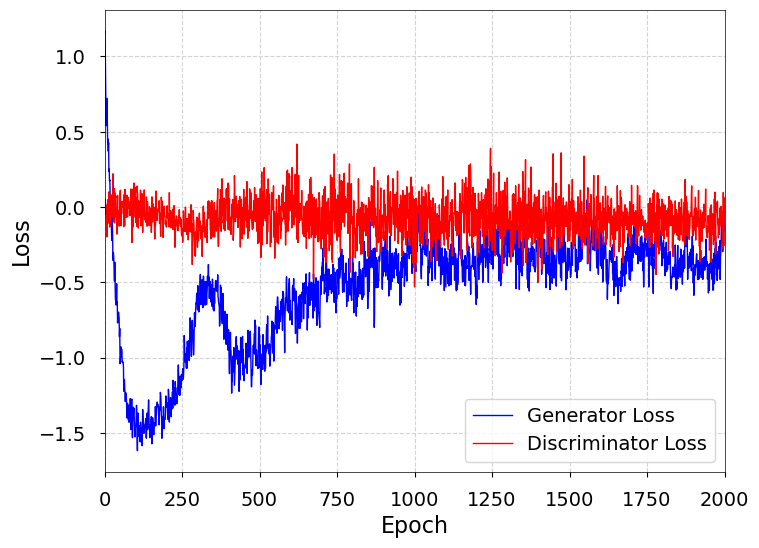

In [18]:
import matplotlib.pyplot as plt

# Create the figure
plt.figure(figsize=(8, 6))

# Plot the lines for Generator Loss and Discriminator Loss
plt.plot(loss_values['Epoch'], loss_values['Generator Loss'], label='Generator Loss', color='blue', linewidth=1)
plt.plot(loss_values['Epoch'], loss_values['Discriminator Loss'], label='Discriminator Loss', color='red', linewidth=1)

# Set the title and labels with desired font sizes
#plt.title('CTGAN Training Loss over Epochs', fontsize=16)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)

# Ensure x-axis starts at 0
plt.xlim(left=0, right = 2000)  # Set the left limit of x-axis to 0

# Adjust tick padding
plt.tick_params(axis='x', which='major', pad=10, labelsize=14)
plt.tick_params(axis='y', which='major', pad=10, labelsize=14)

# Customize grid
plt.grid(color='lightgrey', linestyle='--', linewidth=0.8)

# Move the legend to the exact left-bottom corner
plt.legend(loc='lower right', bbox_to_anchor=(1, 0), fontsize=14)

# Optionally, add a border around the plot
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_color('black')
    spine.set_linewidth(0.5)

# Save the plot with high resolution before showing it.
# Here, dpi=300 sets the resolution to 300 dots per inch.
if save_or_not:
    plt.savefig('../03_output_PAN/draft_plots/36_ctgan_training_loss_0207.png', dpi=600, bbox_inches='tight')

# Show the plot
plt.show()

## 2.0 Evaluate the performance

In [19]:
# generate synthetic data of the same size as the real dataset
# synthetic_data = synthesizer.sample(num_rows=transformed.shape[0])
# synthetic_data.head()

In [20]:
# save the synthetic data
#synthetic_data.to_csv('../03_output_PAN/36_ctgan_synthetic_data_seed666_index_reset_0207_default_2000.csv', index=False)
# read the synthetic data
synthetic_data = pd.read_csv('../03_output_PAN/36_ctgan_synthetic_data_seed666_index_reset_0207_default_2000.csv')
synthetic_data.head()

AgeGroup  Gender  ActionCount  ActionSequence  GradedScore  ResponseTime  \
0    45-49  Female            6        0.159712            7         33985   
1    50-54    Male           25        0.707641            1         97912   
2    16-19    Male           26        0.619337            1        134260   
3    35-39  Female           16        0.105659            7        213415   
4    20-24    Male           21        0.310965            1        197916   

   LiteracyScore  NumeracyScore Country  
0      279.01314      249.67735      UK  
1      275.76138      288.58990      US  
2      319.14865      352.22462      US  
3      345.61646      325.87296      UK  
4      319.14355      322.29320      US

In [21]:
reversed_synthetic = ht.reverse_transform(synthetic_data)

In [22]:
action_count_list = []
# to check the action count for each action sequence
for seq in reversed_synthetic['ActionSequence']:
    # split the sequence by ','
    seq_split = seq.split(',')
    # count the number of actions
    action_count = len(seq_split)
    # append the action count to the list
    action_count_list.append(action_count)

# replace the ActionCount with the generated action count
reversed_synthetic['ActionCount'] = action_count_list
reversed_synthetic.head()

ID AgeGroup  Gender  ActionCount  \
0  0    45-49  Female           13   
1  1    50-54    Male           27   
2  2    16-19    Male           25   
3  3    35-39  Female            7   
4  4    20-24    Male           18   

                                      ActionSequence  GradedScore  \
0  START,COMBOBOX,COMBOBOX,BUTTON,CHECKBOX,BUTTON...            7   
1  START,COMBOBOX,COMBOBOX,TEXTLINK,TEXTLINK,TAB,...            1   
2  START,COMBOBOX,BUTTON,BUTTON,BUTTON,BUTTON,CHE...            1   
3  START,COMBOBOX,COMBOBOX,BUTTON,BUTTON,NEXT_INQ...            7   
4  START,TEXTLINK,TEXTLINK,CHECKBOX,BUTTON,BUTTON...            1   

   ResponseTime  LiteracyScore  NumeracyScore Country  
0         33985      279.01314      249.67735      UK  
1         97912      275.76138      288.58990      US  
2        134260      319.14865      352.22462      US  
3        213415      345.61646      325.87296      UK  
4        197916      319.14355      322.29320      US

In [23]:
# replace the ActionCount in the synthetic data with the generated action count
synthetic_data['ActionCount'] = action_count_list

In [24]:
# Check the data quality
# Quality Score
quality_report = evaluate_quality(transformed, synthetic_data, metadata_0)

# Retrieve details for column shapes
quality_deets = quality_report.get_details(property_name='Column Shapes')

print(quality_deets)

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 9/9 [00:00<00:00, 749.55it/s]|
Column Shapes Score: 95.01%

(2/2) Evaluating Column Pair Trends: |██████████| 36/36 [00:00<00:00, 329.57it/s]|
Column Pair Trends Score: 88.42%

Overall Score (Average): 91.72%

           Column        Metric     Score
0        AgeGroup  TVComplement  0.899816
1          Gender  TVComplement  0.951444
2     ActionCount  KSComplement  0.965274
3  ActionSequence  KSComplement  0.963737
4     GradedScore  KSComplement  0.979717
5    ResponseTime  KSComplement  0.951752
6   LiteracyScore  KSComplement  0.928089
7   NumeracyScore  KSComplement  0.945913
8         Country  TVComplement  0.965581


Here, I will make a good-looking academic style correlation matrix.

In [25]:
df_tempt = df.copy()
reversed_synthetic_tempt = reversed_synthetic.copy()

df_tempt.drop(columns=['ID'], inplace=True)
# add the ActionCount column to the reversed synthetic data
reversed_synthetic_tempt['ActionCount'] = action_count_list
# drop the ID column
reversed_synthetic_tempt.drop(columns=['ID'], inplace=True)

# create the metadata using auto-detect
metadata_tempt = SingleTableMetadata()
metadata_tempt.detect_from_dataframe(df_tempt)
# revise the metadata
metadata_tempt.update_column(
    column_name='GradedScore',
    sdtype='numerical'
)

# change the columns order in reversed synthetic data the same with df_tempt
reversed_synthetic_tempt = reversed_synthetic_tempt[df_tempt.columns]

# get the quality report
quality_report_tempt = evaluate_quality(df_tempt, reversed_synthetic_tempt, metadata_tempt)

correlation_scores = quality_report_tempt.get_details(property_name='Column Pair Trends')
# drop the rows with NaN values
correlation_scores = correlation_scores.dropna()

# get the average of column Metric
average_metric = correlation_scores['Score'].mean()
print(f'Average Metric: {average_metric}')

Generating report ...

(1/2) Evaluating Column Shapes: |          | 0/9 [00:00<?, ?it/s]|

(1/2) Evaluating Column Shapes: |██████████| 9/9 [00:00<00:00, 233.67it/s]|
Column Shapes Score: 92.14%

(2/2) Evaluating Column Pair Trends: |██████████| 36/36 [00:00<00:00, 247.53it/s]|
Column Pair Trends Score: 76.45%

Overall Score (Average): 84.3%

Average Metric: 0.961653407309503


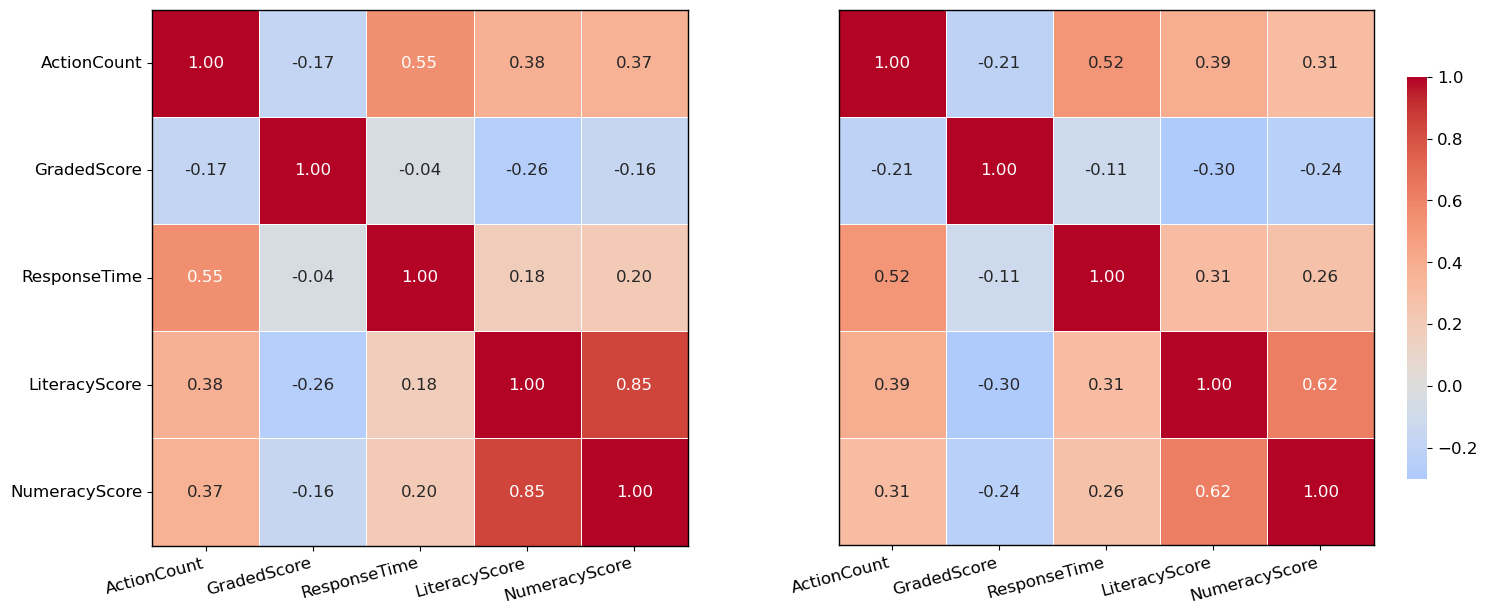

In [26]:
annot_show = True # whether to show the annotations in the heatmap

# transformed means the real data
corr_matrix_real = transformed.drop(columns=['Country', 'Gender', 'AgeGroup', 'ActionSequence']).corr()
corr_matrix_fake = synthetic_data.drop(columns=['Country', 'Gender', 'AgeGroup', 'ActionSequence']).corr()

# Create a figure with two subplots side by side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# Plot the first correlation matrix on the left subplot
sns.heatmap(
    corr_matrix_real,
    annot=annot_show,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    square=True,
    linewidths=0.5,
    # cbar_kws={"shrink": 0.75},
    cbar = False, # to remove the color bar
    ax=axes[0],  # Specify the Axes to plot on
    annot_kws={"size": 12} # Adjust the font size of the annotations
)
# axes[0].set_title("Correlation Matrix of Real Data", fontsize=16, pad=12)
axes[0].tick_params(axis='x', labelsize=12)
axes[0].tick_params(axis='y', labelsize=12)

axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=15, ha='right')
axes[0].set_yticklabels(axes[0].get_yticklabels(), ha='right')

# Plot the second correlation matrix on the right subplot
sns.heatmap(
    corr_matrix_fake,
    annot=annot_show,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    square=True,
    linewidths=0.5,
    cbar=True, # to show the color bar
    cbar_kws={"shrink": 0.75}, # Adjust the color bar
    ax=axes[1],  # Specify the Axes to plot on
    annot_kws={"size": 12} # Adjust the font size of the annotations
).collections[0].colorbar.ax.tick_params(labelsize=12)

# axes[1].set_title("Correlation Matrix of Synthetic Data", fontsize=16, pad=12)
axes[1].tick_params(axis='x', labelsize=12)
axes[1].tick_params(axis='y', left = False, labelleft=False, labelsize=12)


axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=15, ha='right')
#axes[1].set_yticklabels(axes[1].get_yticklabels(), rotation=45, ha='right')

plt.subplots_adjust(wspace=1)

# Ensure that the frame is visible in both subplots:
for ax in axes:
    # Make sure the axes frame is turned on
    ax.set_frame_on(True)
    # Make the background patch transparent so the spines are visible on top
    ax.patch.set_visible(False)
    # Loop through each spine and set its properties
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_edgecolor('black')
        spine.set_linewidth(1.0)

# Adjust the layout so that the subplots do not overlap
plt.tight_layout()

# Save the figure if desired
if save_or_not:
    plt.savefig("../03_output_PAN/draft_plots/36_two_correlation_matrices_2000epoch_no_annote.png", dpi=600, bbox_inches='tight')

# Display the figure
plt.show()

make the density plot of response time of real vs. synthetic data

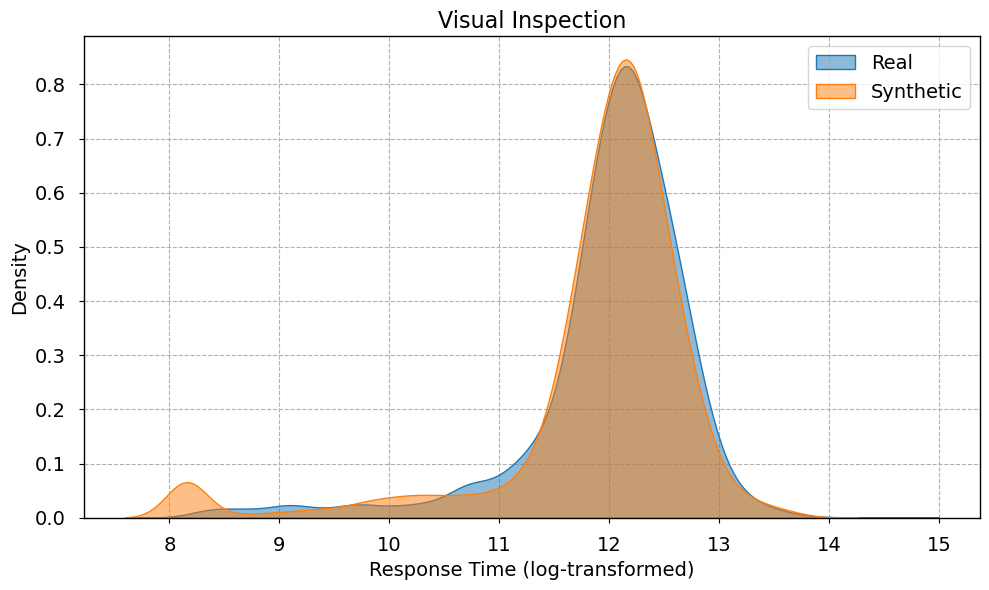

In [26]:
# extract the ResponseTime column from the synthetic data
response_fake = pd.DataFrame({"ResponseTime":synthetic_data['ResponseTime'], "Dataset": "Synthetic"})
response_real = pd.DataFrame({"ResponseTime":transformed['ResponseTime'], "Dataset": "Real"})

response_fake["ResponseTime"] = np.log1p(response_fake["ResponseTime"])
response_real["ResponseTime"] = np.log1p(response_real["ResponseTime"])

# combine the two dataframes
response = pd.concat([response_fake, response_real], ignore_index=True)

# using the log scale
# response['ResponseTime'] = np.log1p(response['ResponseTime'])

# Create the plot
plt.figure(figsize=(10, 6))
ax = plt.gca()

# Ensure that grid lines are drawn below the density curves
ax.set_axisbelow(True)

# Add grid lines with dashed style
plt.grid(linestyle='--', linewidth=0.8)

# Plot density curves separately with manual labels to force legend entries
sns.kdeplot(data=response_real, x='ResponseTime', fill=True, alpha=0.5,
            label='Real', common_norm=False, ax=ax)
sns.kdeplot(data=response_fake, x='ResponseTime', fill=True, alpha=0.5,
            label='Synthetic', common_norm=False, ax=ax)

# --- Customize the Frame ---
# Set the axes (plot) spines to be black and thicker.
for spine in ax.spines.values():
    spine.set_edgecolor("black")
    spine.set_linewidth(1.0)

# Adjust tick padding
plt.tick_params(axis='x', which='major', pad=10, labelsize=14)
plt.tick_params(axis='y', which='major', pad=10, labelsize=14)

# Customize the legend to ensure it shows both identities
plt.legend(fontsize=14)

# Customize plot title and axis labels
plt.title("Visual Inspection", fontsize=16)
plt.xlabel("Response Time (log-transformed)", fontsize=14)
plt.ylabel("Density", fontsize=14)

# Adjust layout and save the figure
plt.tight_layout()
if save_or_not:
    plt.savefig("../03_output_PAN/draft_plots/36_response_time_density_with_grid_2000epoch.png", dpi=600, bbox_inches='tight')
plt.show()

data visulation for the literacy score and numeracy score.

In [27]:
transformed.columns

Index(['AgeGroup', 'Gender', 'ActionCount', 'ActionSequence', 'GradedScore',
       'ResponseTime', 'LiteracyScore', 'NumeracyScore', 'Country'],
      dtype='object')

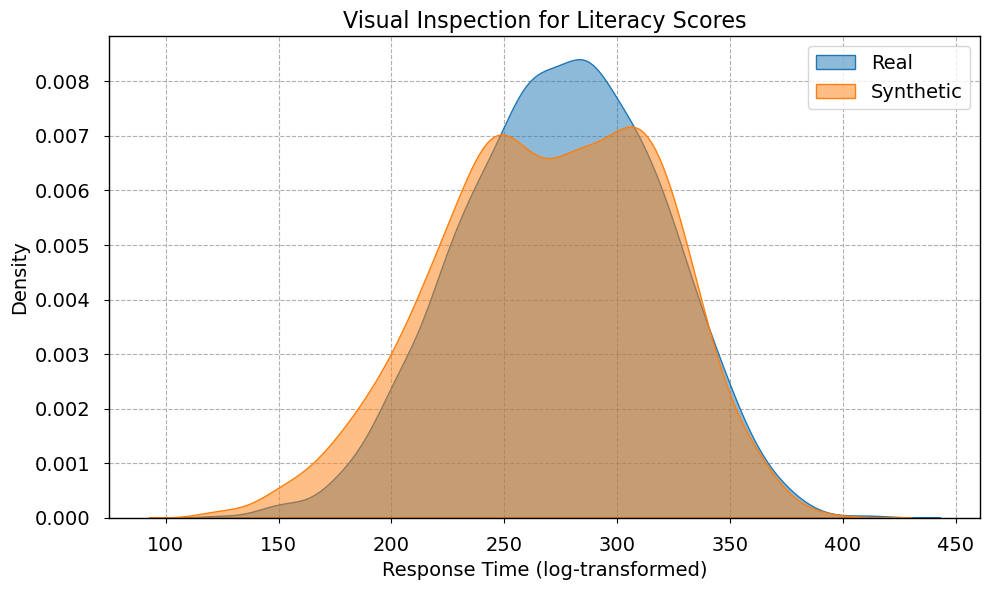

In [28]:
# visualize the distribution of the LiteracyScore, using the variable names as above.

# extract the ResponseTime column from the synthetic data
response_fake = pd.DataFrame({"ResponseTime":synthetic_data['LiteracyScore'], "Dataset": "Synthetic"})
response_real = pd.DataFrame({"ResponseTime":transformed['LiteracyScore'], "Dataset": "Real"})


# combine the two dataframes
response = pd.concat([response_fake, response_real], ignore_index=True)

# using the log scale
# response['ResponseTime'] = np.log1p(response['ResponseTime'])

# Create the plot
plt.figure(figsize=(10, 6))
ax = plt.gca()

# Ensure that grid lines are drawn below the density curves
ax.set_axisbelow(True)

# Add grid lines with dashed style
plt.grid(linestyle='--', linewidth=0.8)

# Plot density curves separately with manual labels to force legend entries
sns.kdeplot(data=response_real, x='ResponseTime', fill=True, alpha=0.5,
            label='Real', common_norm=False, ax=ax)
sns.kdeplot(data=response_fake, x='ResponseTime', fill=True, alpha=0.5,
            label='Synthetic', common_norm=False, ax=ax)

# --- Customize the Frame ---
# Set the axes (plot) spines to be black and thicker.
for spine in ax.spines.values():
    spine.set_edgecolor("black")
    spine.set_linewidth(1.0)

# Adjust tick padding
plt.tick_params(axis='x', which='major', pad=10, labelsize=14)
plt.tick_params(axis='y', which='major', pad=10, labelsize=14)

# Customize the legend to ensure it shows both identities
plt.legend(fontsize=14)

# Customize plot title and axis labels
plt.title("Visual Inspection for Literacy Scores", fontsize=16)
plt.xlabel("Response Time (log-transformed)", fontsize=14)
plt.ylabel("Density", fontsize=14)

# Adjust layout and save the figure
plt.tight_layout()
if save_or_not:
    plt.savefig("../03_output_PAN/draft_plots/36_response_time_density_with_grid_2000epoch.png", dpi=600, bbox_inches='tight')
plt.show()

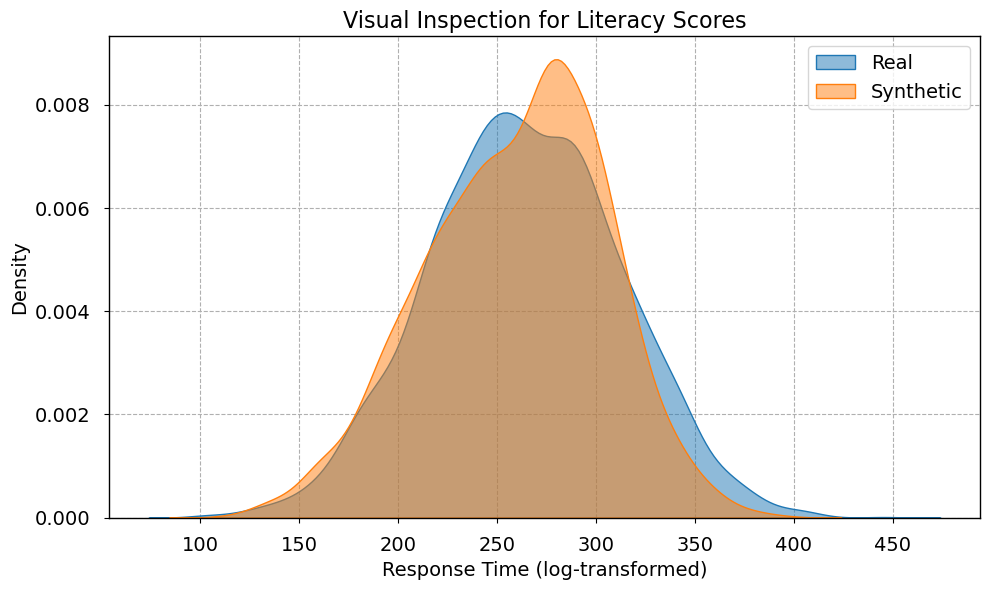

In [29]:
# visualize the distribution of the LiteracyScore, using the variable names as above.

# extract the ResponseTime column from the synthetic data
response_fake = pd.DataFrame({"ResponseTime":synthetic_data['NumeracyScore'], "Dataset": "Synthetic"})
response_real = pd.DataFrame({"ResponseTime":transformed['NumeracyScore'], "Dataset": "Real"})


# combine the two dataframes
response = pd.concat([response_fake, response_real], ignore_index=True)

# using the log scale
# response['ResponseTime'] = np.log1p(response['ResponseTime'])

# Create the plot
plt.figure(figsize=(10, 6))
ax = plt.gca()

# Ensure that grid lines are drawn below the density curves
ax.set_axisbelow(True)

# Add grid lines with dashed style
plt.grid(linestyle='--', linewidth=0.8)

# Plot density curves separately with manual labels to force legend entries
sns.kdeplot(data=response_real, x='ResponseTime', fill=True, alpha=0.5,
            label='Real', common_norm=False, ax=ax)
sns.kdeplot(data=response_fake, x='ResponseTime', fill=True, alpha=0.5,
            label='Synthetic', common_norm=False, ax=ax)

# --- Customize the Frame ---
# Set the axes (plot) spines to be black and thicker.
for spine in ax.spines.values():
    spine.set_edgecolor("black")
    spine.set_linewidth(1.0)

# Adjust tick padding
plt.tick_params(axis='x', which='major', pad=10, labelsize=14)
plt.tick_params(axis='y', which='major', pad=10, labelsize=14)

# Customize the legend to ensure it shows both identities
plt.legend(fontsize=14)

# Customize plot title and axis labels
plt.title("Visual Inspection for Literacy Scores", fontsize=16)
plt.xlabel("Response Time (log-transformed)", fontsize=14)
plt.ylabel("Density", fontsize=14)

# Adjust layout and save the figure
plt.tight_layout()
if save_or_not:
    plt.savefig("../03_output_PAN/draft_plots/36_response_time_density_with_grid_2000epoch.png", dpi=600, bbox_inches='tight')
plt.show()

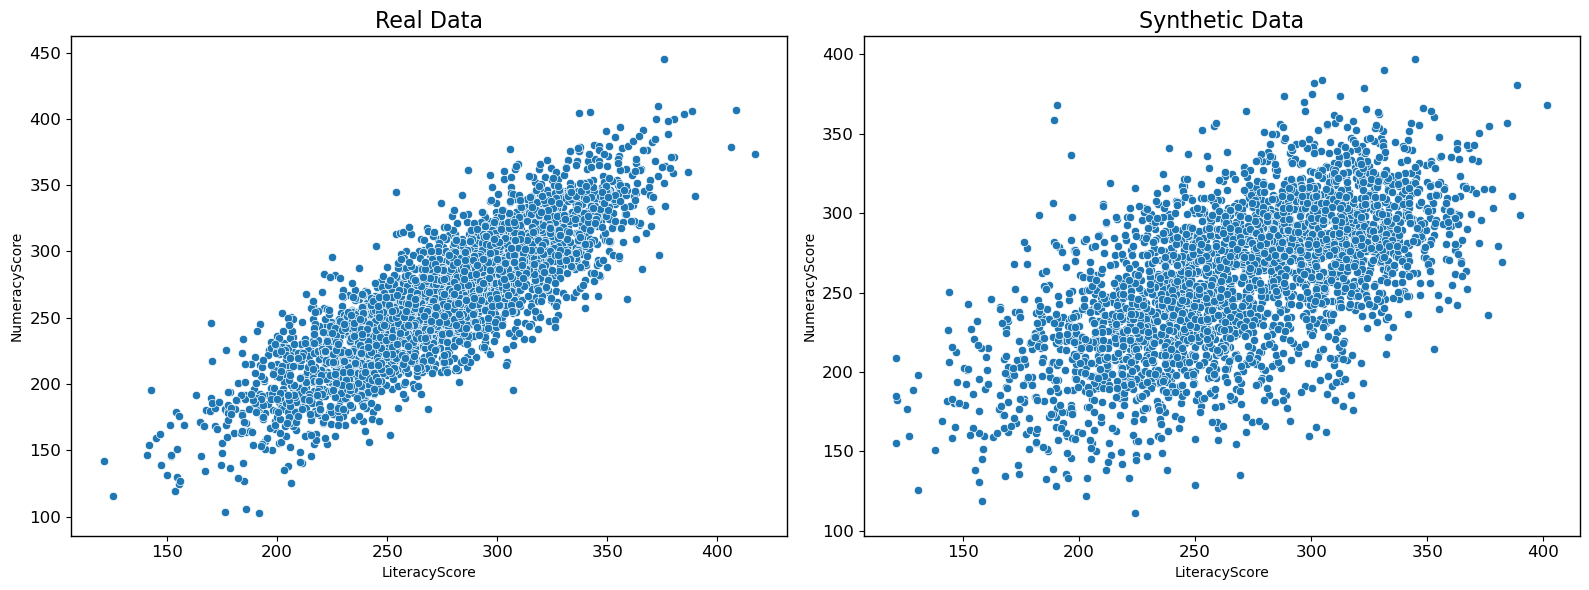

In [30]:
# visulize the NumeracyScore and LiteracyScore's correlation in the real and synthetic data
# Create a figure with two subplots side by side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# Plot the first correlation matrix on the left subplot
sns.scatterplot(data=transformed, x='LiteracyScore', y='NumeracyScore', ax=axes[0])
axes[0].set_title("Real Data", fontsize=16)
axes[0].tick_params(axis='x', labelsize=12)
axes[0].tick_params(axis='y', labelsize=12)

# Plot the second correlation matrix on the right subplot
sns.scatterplot(data=synthetic_data, x='LiteracyScore', y='NumeracyScore', ax=axes[1])
axes[1].set_title("Synthetic Data", fontsize=16)
axes[1].tick_params(axis='x', labelsize=12)
axes[1].tick_params(axis='y', labelsize=12)

# Ensure that the frame is visible in both subplots:
for ax in axes:
    # Make sure the axes frame is turned on
    ax.set_frame_on(True)
    # Make the background patch transparent so the spines are visible on top
    ax.patch.set_visible(False)
    # Loop through each spine and set its properties
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_edgecolor('black')
        spine.set_linewidth(1.0)

# Adjust the layout so that the subplots do not overlap
plt.tight_layout()

# Save the figure if desired
if save_or_not:
    plt.savefig("../03_output_PAN/draft_plots/36_two_correlation_matrices_2000epoch_no_annote.png", dpi=600, bbox_inches='tight')

# Display the figure
plt.show()

In [ ]:
# calculate the variances of LiteracyScore in the real and synthetic data
real_var = transformed['LiteracyScore'].var()
fake_var = synthetic_data['LiteracyScore'].var()

real_var, fake_var

(1937.4320095550472, 2350.4424442461273)

In [32]:
# calculate the variances of NumeracyScore in the real and synthetic data
real_var = transformed['NumeracyScore'].var()
fake_var = synthetic_data['NumeracyScore'].var()

real_var, fake_var

(2349.9918140122754, 2070.6306625304346)

In [33]:
# calculate the correlation of LiteracyScore and NumeracyScore in the real and synthetic data
real_corr = transformed['LiteracyScore'].corr(transformed['NumeracyScore'])
fake_corr = synthetic_data['LiteracyScore'].corr(synthetic_data['NumeracyScore'])

real_corr, fake_corr

(0.8488196121848142, 0.6214480599007269)

In [34]:
# calculate the covariance of the LiteracyScore and NumeracyScore in the real and synthetic data
real_cov = transformed['LiteracyScore'].cov(transformed['NumeracyScore'])
fake_cov = synthetic_data['LiteracyScore'].cov(synthetic_data['NumeracyScore'])

real_cov, fake_cov

(1811.1808413572767, 1370.9795207121654)

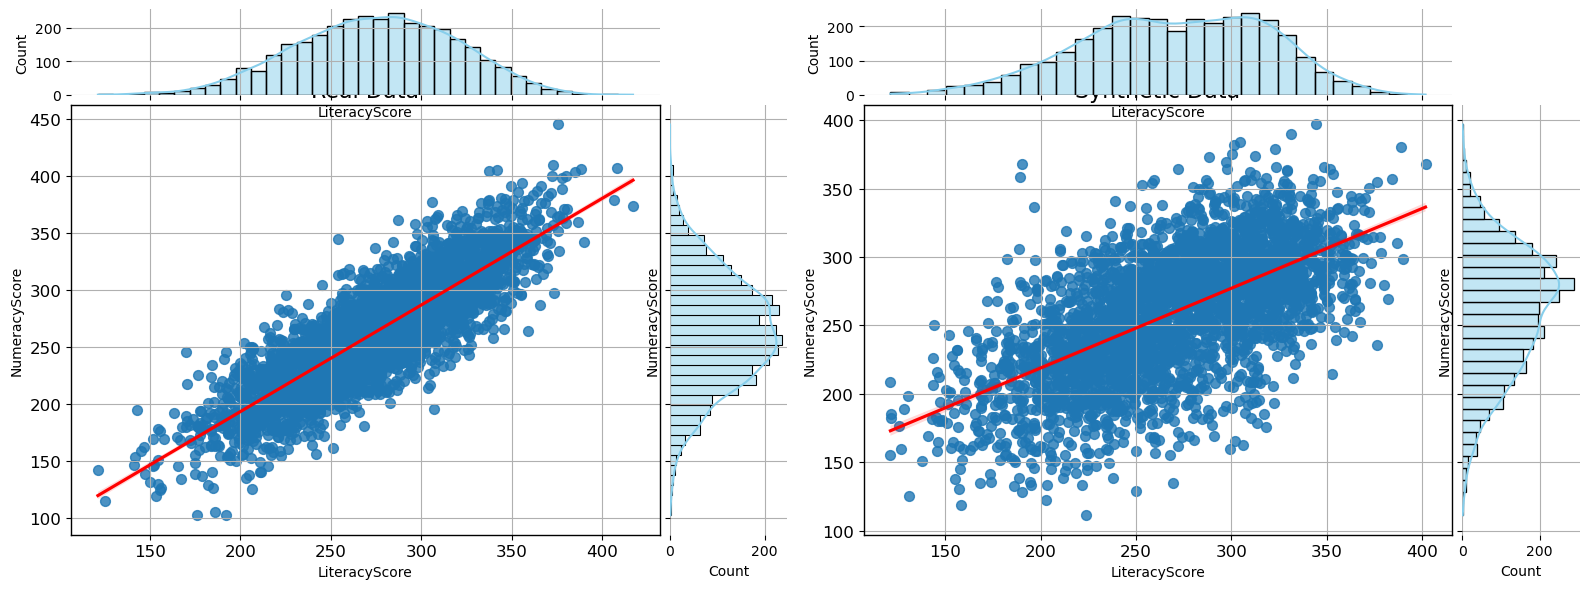

In [31]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
# Create a figure with two subplots side by side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# Define a list of tuples: (data, title) for each subplot
datasets = [(transformed, "Real Data"), (synthetic_data, "Synthetic Data")]

for ax, (data, title) in zip(axes, datasets):
    # Plot the main scatter plot with regression line.
    # sns.regplot() adds a regression line along with the scatter points.
    sns.regplot(data=data, 
                x='LiteracyScore', 
                y='NumeracyScore', 
                ax=ax,
                scatter_kws={'s': 50},       # adjust marker size if desired
                line_kws={'color': 'red'}     # regression line in red
               )
    
    # Customize the central axes
    ax.set_title(title, fontsize=16)
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    ax.grid(True)  # add grid lines to the main plot
    
    # Ensure the axes frame is visible and nicely styled
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_edgecolor('black')
        spine.set_linewidth(1.0)
    
    # --- Add Marginal Histograms ---
    # Use the axes divider to create new axes for the marginals.
    divider = make_axes_locatable(ax)
    ax_histx = divider.append_axes("top", size="20%", pad=0.1, sharex=ax)
    ax_histy = divider.append_axes("right", size="20%", pad=0.1, sharey=ax)
    
    # Plot the marginal distribution for LiteracyScore (top) and NumeracyScore (right)
    sns.histplot(data=data, x='LiteracyScore', ax=ax_histx, kde=True, color='skyblue')
    sns.histplot(data=data, y='NumeracyScore', ax=ax_histy, kde=True, color='skyblue')
    
    # Add grid lines to the marginal histograms as well
    ax_histx.grid(True)
    ax_histy.grid(True)
    
    # Remove redundant tick labels on the marginal plots to reduce clutter
    plt.setp(ax_histx.get_xticklabels(), visible=False)
    plt.setp(ax_histy.get_yticklabels(), visible=False)
    
    # (Optional) Remove the spines from the marginal plots for a cleaner look
    for spine in ax_histx.spines.values():
        spine.set_visible(False)
    for spine in ax_histy.spines.values():
        spine.set_visible(False)

# Adjust the layout so that subplots and their marginals do not overlap
plt.tight_layout()

# Save the figure if desired
if save_or_not:
    plt.savefig("../03_output_PAN/draft_plots/36_two_correlation_matrices_2000epoch_no_annote.png", 
                dpi=600, bbox_inches='tight')

# Display the figure
plt.show()


### 2.2.0 Evaluate the performance of the synthetic data

In [32]:
# create the metadata using auto-detect
metadata_test = SingleTableMetadata()
metadata_test.detect_from_dataframe(synthetic_data)

metadata_test.update_column(
    column_name='GradedScore',
    sdtype='numerical'
)

metadata_test

{
    "columns": {
        "AgeGroup": {
            "sdtype": "categorical"
        },
        "Gender": {
            "sdtype": "categorical"
        },
        "ActionCount": {
            "sdtype": "numerical"
        },
        "ActionSequence": {
            "sdtype": "numerical"
        },
        "GradedScore": {
            "sdtype": "numerical"
        },
        "ResponseTime": {
            "sdtype": "numerical"
        },
        "LiteracyScore": {
            "sdtype": "numerical"
        },
        "NumeracyScore": {
            "sdtype": "numerical"
        },
        "Country": {
            "sdtype": "categorical"
        }
    },
    "METADATA_SPEC_VERSION": "SINGLE_TABLE_V1"
}

In [33]:
# Quality Score: transformed vs synthetic data
quality_report1 = evaluate_quality(transformed, synthetic_data, metadata_test)

# Retrieve details for column shapes
quality_deets1 = quality_report1.get_details(property_name='Column Shapes')

print(quality_deets1)

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 9/9 [00:00<00:00, 941.44it/s]|
Column Shapes Score: 95.02%

(2/2) Evaluating Column Pair Trends: |██████████| 36/36 [00:00<00:00, 336.50it/s]|
Column Pair Trends Score: 88.43%

Overall Score (Average): 91.72%

           Column        Metric     Score
0        AgeGroup  TVComplement  0.899816
1          Gender  TVComplement  0.951444
2     ActionCount  KSComplement  0.965274
3  ActionSequence  KSComplement  0.964044
4     GradedScore  KSComplement  0.979717
5    ResponseTime  KSComplement  0.951752
6   LiteracyScore  KSComplement  0.928089
7   NumeracyScore  KSComplement  0.945913
8         Country  TVComplement  0.965581


### 2.2 Evaluate the performance of the reversed data

In [34]:
# create the metadata using auto-detect
metadata_test = SingleTableMetadata()
metadata_test.detect_from_dataframe(reversed_synthetic)

metadata_test.update_column(
    column_name='GradedScore',
    sdtype='numerical'
)

metadata_test.update_column(
    column_name='ActionSequence',
    sdtype='categorical'
)

# Quality Score
quality_report1 = evaluate_quality(df, reversed_synthetic, metadata_test)

# Retrieve details for column shapes
quality_deets1 = quality_report1.get_details(property_name='Column Shapes')

print(quality_deets1)

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 10/10 [00:00<00:00, 198.84it/s]|
Column Shapes Score: 92.14%

(2/2) Evaluating Column Pair Trends: |██████████| 45/45 [00:00<00:00, 332.42it/s]|
Column Pair Trends Score: 76.45%

Overall Score (Average): 84.3%

           Column        Metric     Score
0        AgeGroup  TVComplement  0.899816
1          Gender  TVComplement  0.951444
2     ActionCount  KSComplement  0.965274
3  ActionSequence  TVComplement  0.705286
4     GradedScore  KSComplement  0.979717
5    ResponseTime  KSComplement  0.951752
6   LiteracyScore  KSComplement  0.928089
7   NumeracyScore  KSComplement  0.945913
8         Country  TVComplement  0.965581


In [35]:
# get the score of generalization
from sdmetrics.single_table import NewRowSynthesis

general_score = NewRowSynthesis.compute(
    real_data = df,
    synthetic_data = reversed_synthetic,
    metadata=metadata_test,
    numerical_match_tolerance=0.01,
    synthetic_sample_size=None,
)

In [36]:
general_score

1.0

In [37]:
quality_html= quality_report1.get_visualization('Column Shapes')
print(type(quality_html))
quality_html.show(renderer='vscode')

<class 'plotly.graph_objs._figure.Figure'>


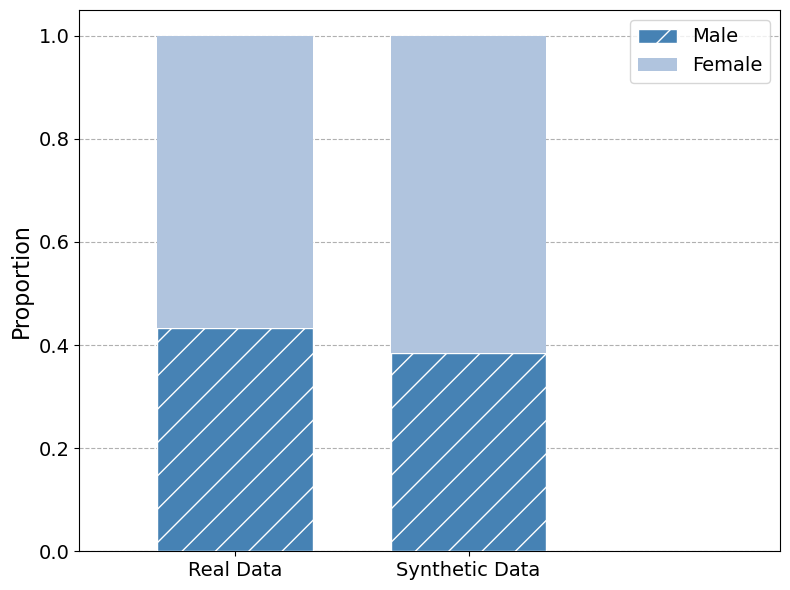

In [39]:
# Calculate normalized gender counts for real and synthetic data
real_counts = df['Gender'].value_counts(normalize=True)
synth_counts = synthetic_data['Gender'].value_counts(normalize=True)

male_prop = real_counts.get('Male', 0)
female_prop = real_counts.get('Female', 0)
real_props = [male_prop, female_prop]

male_prop_synth = synth_counts.get('Male', 0)
female_prop_synth = synth_counts.get('Female', 0)
synth_props = [male_prop_synth, female_prop_synth]

# x positions for the two bars (closer together)
x = [-0.05, 0.10]

# Create figure
plt.figure(figsize=(8, 6))

# Add grid lines behind the bars
plt.grid(axis='y', linestyle='--', linewidth=0.8, zorder=0)

# Plot the male part (base)
plt.bar(x, [real_props[0], synth_props[0]], 
        color='steelblue', hatch='/', edgecolor='white', width=0.10, 
        label='Male', zorder=3)

# Plot the female part on top
plt.bar(x, [real_props[1], synth_props[1]], bottom=[real_props[0], synth_props[0]],
        color='lightsteelblue', width=0.10, linewidth=1.5, label='Female', zorder=3)

# Add x-tick labels
plt.xticks(x, ['Real Data', 'Synthetic Data'], fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("Proportion", fontsize=16)

# Reduce empty space on the right
plt.xlim(-0.15, 0.30)

# Move legend slightly inside
plt.legend(fontsize=14, loc='upper right')

plt.tight_layout()
plt.show()


plot the quality metrics to be in academic style

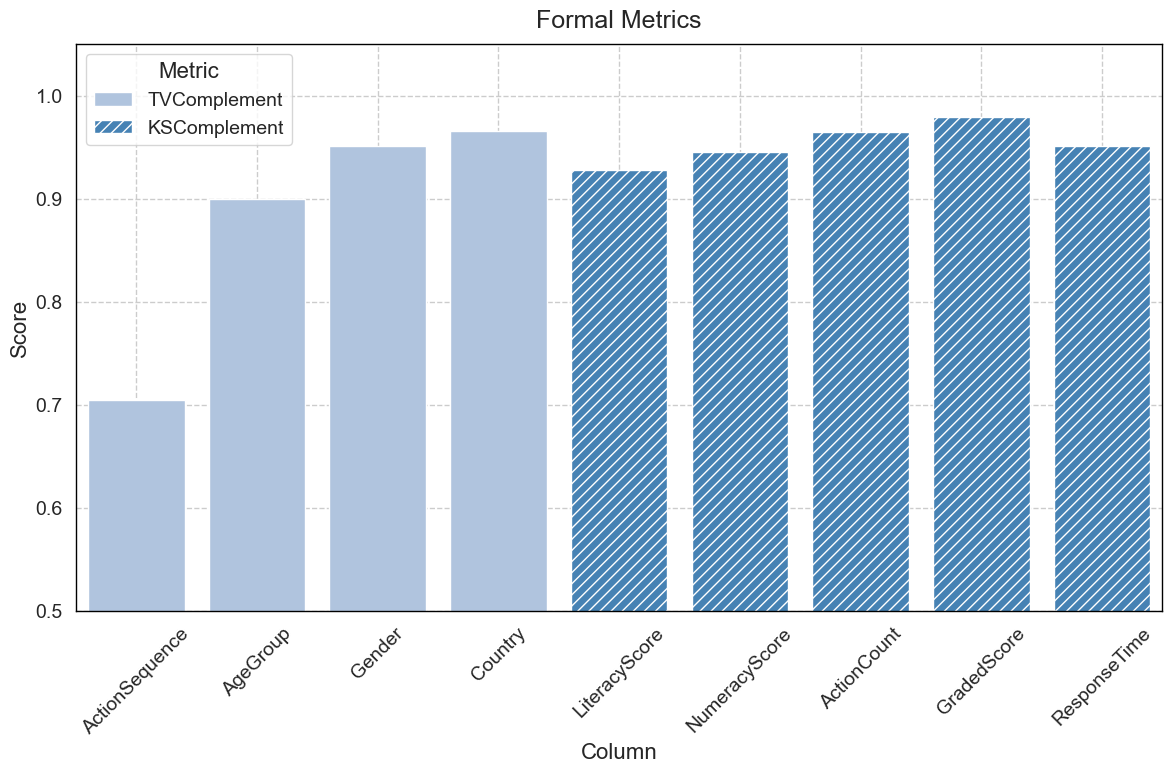

In [40]:
from matplotlib.patches import Patch

custom_order = ["ActionSequence","AgeGroup", "Gender", "Country","LiteracyScore", "NumeracyScore", "ActionCount", "GradedScore", "ResponseTime"]

# Create a mapping from Column to Metric for later customization.
metric_mapping = quality_deets1.set_index('Column')['Metric'].to_dict()

# Set a style that is academic in nature.
sns.set_theme(style="whitegrid", font_scale=1.3)

# Create the figure and axis
plt.figure(figsize=(12, 8))

# Create a bar plot with "Column" on x-axis, "Score" on y-axis and hue based on "Metric"
ax = sns.barplot(data=quality_deets1, x='Column', y='Score', hue='Metric', palette='Set2', order=custom_order)

# Set y-axis to start from 0.5
plt.ylim(0.5, 1.05)

# Add title and axis labels with larger font sizes
plt.title("Formal Metrics", fontsize=18, pad=12)
plt.xlabel("Column", fontsize=16)
plt.ylabel("Score", fontsize=16)

# Rotate x-axis labels for better readability and adjust tick font sizes
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)

# Customize the legend: set title and font sizes
plt.legend(title='Metric', fontsize=14, title_fontsize=16)


# --- Customize Bars ---
# Iterate over each bar (patch) and customize its appearance.
# The order of patches in ax.patches follows the order of categories (custom_order).
for patch, col in zip(ax.patches, custom_order):
    metric = metric_mapping[col]
    if metric == "TVComplement":
        # For TVComplement, ensure the bar is lightsteelblue.
        patch.set_facecolor("lightsteelblue")
    elif metric == "KSComplement":
        # For KSComplement, set the face color to steelblue and add a hatch pattern.
        patch.set_facecolor("steelblue")
        patch.set_hatch("///")

# --- Create Custom Legend ---
# Instead of using the automatically generated legend, we create custom legend handles.
legend_elements = [
    Patch(facecolor="lightsteelblue", label="TVComplement"),
    Patch(facecolor="steelblue", hatch="///", label="KSComplement")
]
ax.legend(handles=legend_elements, title='Metric', fontsize=14, title_fontsize=16)

# --- Customize the Frame ---
# Set the axes (plot) spines to be black and thicker.
for spine in ax.spines.values():
    spine.set_edgecolor("black")
    spine.set_linewidth(1.0)

# Enhance grid lines: ensure they appear behind the bars, with dashed style and increased line width
ax.set_axisbelow(True)
plt.grid(True, linestyle='--', linewidth=1)

# Adjust layout to avoid clipping of labels
plt.tight_layout()

# Save the plot with high resolution if needed
if save_or_not:
    plt.savefig("../03_output_PAN/draft_plots/36_Barplot_TVC_KSC_2000epoch.png", dpi=600, bbox_inches='tight')

# Display the plot
plt.show()

Combine the density curves and bar plots together

C:\Users\grepa\AppData\Local\Temp\ipykernel_10692\3631523925.py:85: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



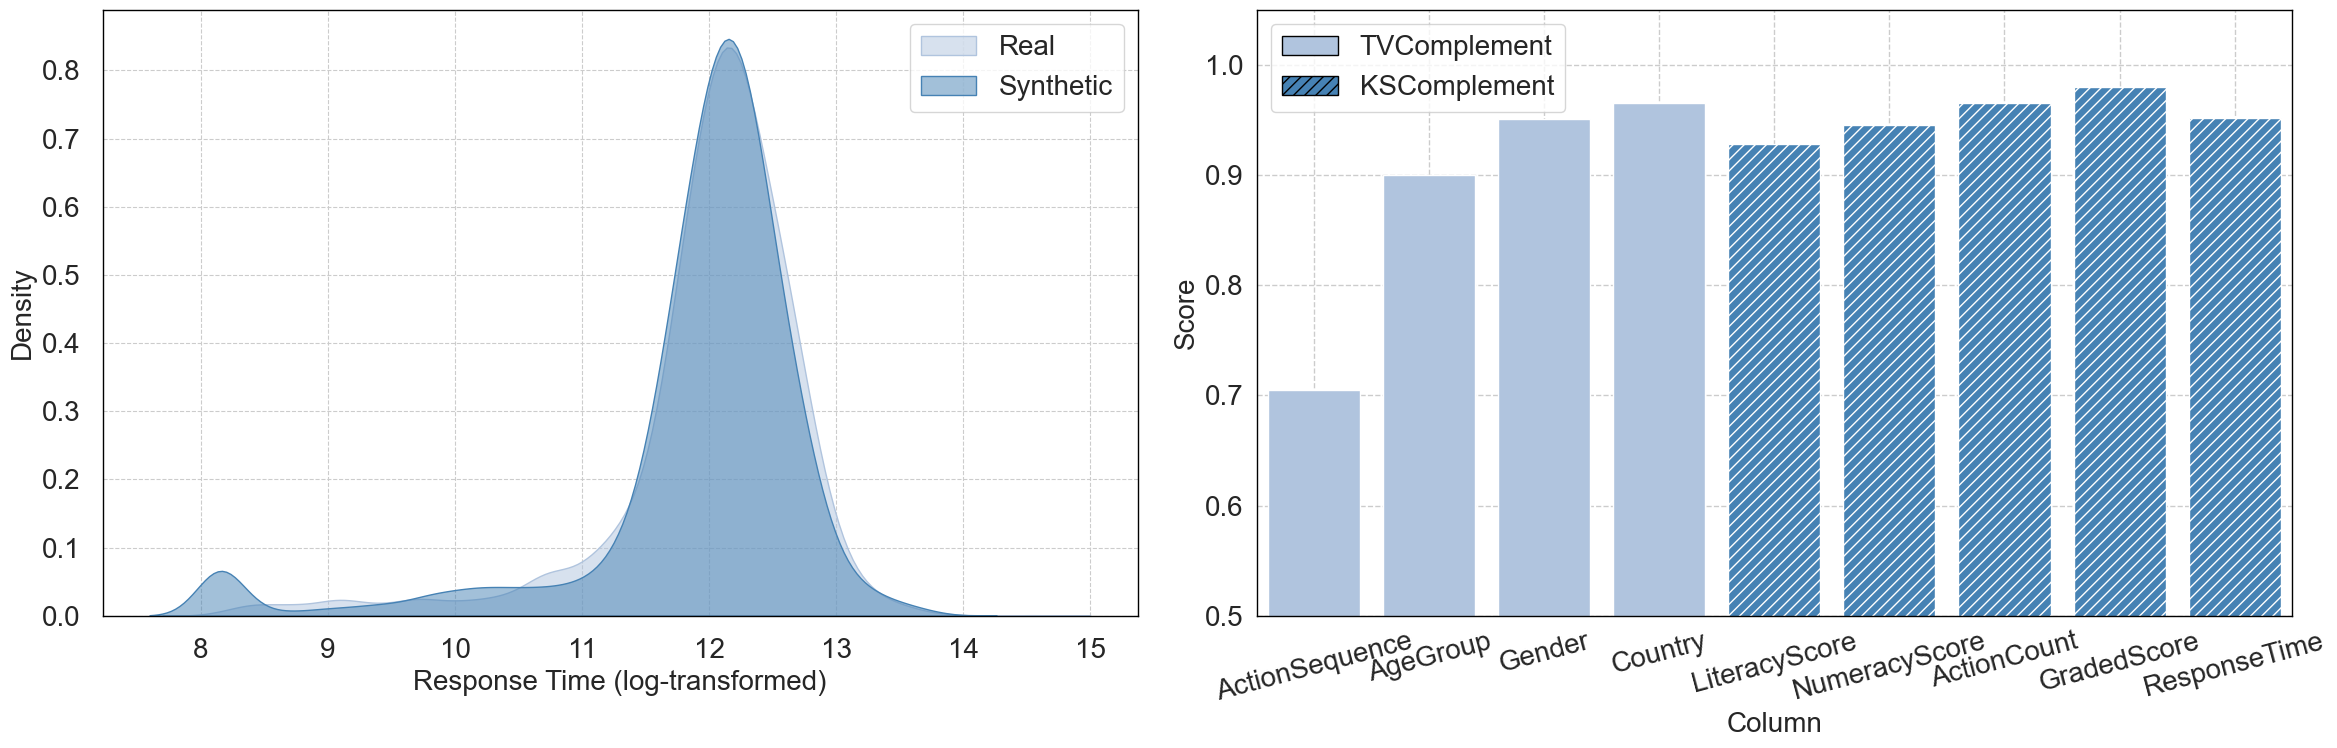

In [41]:
font_size = 20

# ========================================
# Data Preparation for the Density Plot
# ========================================
# Extract the ResponseTime column from synthetic and real data
response_fake = pd.DataFrame({"ResponseTime": synthetic_data['ResponseTime'], "Dataset": "Synthetic"})
response_real = pd.DataFrame({"ResponseTime": transformed['ResponseTime'], "Dataset": "Real"})

# Log-transform the ResponseTime column
response_fake["ResponseTime"] = np.log1p(response_fake["ResponseTime"])
response_real["ResponseTime"] = np.log1p(response_real["ResponseTime"])

# ========================================
# Data Preparation for the Bar Plot
# ========================================
# quality_deets1 is assumed to have columns: Column, Metric, Score.
# Define the custom order with "ActionSequence" as the first bar.
custom_order = ["ActionSequence", "AgeGroup", "Gender", "Country", 
                "LiteracyScore", "NumeracyScore", "ActionCount", "GradedScore", "ResponseTime"]

# Create a mapping from Column to Metric for later bar customization.
metric_mapping = quality_deets1.set_index('Column')['Metric'].to_dict()

# ========================================
# Create a Figure with Two Subplots
# ========================================
fig, axes = plt.subplots(1, 2, figsize=(24, 8))  # left: density, right: bar plot

# ---------------------------
# Left Subplot: Density Plot
# ---------------------------
ax1 = axes[0]
# (Optional) Set an academic theme for consistency.
sns.set_theme(style="whitegrid", font_scale=2)

# Ensure grid lines are drawn below the density curves and add dashed grid lines.
ax1.set_axisbelow(True)
ax1.grid(linestyle='--', linewidth=0.8)

# Plot the density curves for the real and synthetic data.
sns.kdeplot(data=response_real, x='ResponseTime', fill=True, alpha=0.5,
            label='Real', common_norm=False, color="lightsteelblue", ax=ax1)
sns.kdeplot(data=response_fake, x='ResponseTime', fill=True, alpha=0.5,
            label='Synthetic', common_norm=False, color="steelblue", ax=ax1)

# Customize the frame (spines) for the density plot.
for spine in ax1.spines.values():
    spine.set_edgecolor("black")
    spine.set_linewidth(1.0)

# Adjust tick parameters.
ax1.tick_params(axis='x', which='major', pad=10, labelsize=font_size)
ax1.tick_params(axis='y', which='major', pad=10, labelsize=font_size)

# Set the title and axis labels.
# ax1.set_title("Visual Inspection", fontsize=font_size, pad = 16)
ax1.set_xlabel("Response Time (log-transformed)", fontsize=font_size)
ax1.set_ylabel("Density", fontsize=font_size)

# Add and customize the legend.
ax1.legend(fontsize=font_size)

# ---------------------------
# Right Subplot: Bar Plot
# ---------------------------
ax2 = axes[1]

# (Optional) Set an academic theme for consistency.
sns.set_theme(style="whitegrid", font_scale=2)

# Create the bar plot with Column on the x-axis, Score on the y-axis, and hue based on Metric.
sns.barplot(data=quality_deets1, x='Column', y='Score', hue='Metric',
            palette='Set2', order=custom_order, ax=ax2)

# Set the y-axis to start from 0.5 and extend slightly above 1.
ax2.set_ylim(0.5, 1.05)

# Set title and axis labels for the bar plot.
# ax2.set_title("Formal Metrics", fontsize=font_size, pad=16)
ax2.set_xlabel("Column", fontsize=font_size)
ax2.set_ylabel("Score", fontsize=font_size)

# Rotate x-axis tick labels for better readability.
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=15, fontsize=font_size)
ax2.tick_params(axis='y', labelsize=font_size)

# Customize the appearance of each bar based on its Metric.
for patch, col in zip(ax2.patches, custom_order):
    metric = metric_mapping[col]
    if metric == "TVComplement":
        patch.set_facecolor("lightsteelblue")
        patch.set_hatch("")  # no hatch for TVComplement
    elif metric == "KSComplement":
        patch.set_facecolor("steelblue")
        patch.set_hatch("///")

# Create custom legend handles so the legend shows the correct colors and hatches.
legend_elements = [
    Patch(facecolor="lightsteelblue", label="TVComplement", edgecolor="black"),
    Patch(facecolor="steelblue", hatch="///", label="KSComplement", edgecolor="black")
]
ax2.legend(handles=legend_elements, fontsize=font_size)

# Customize the frame (spines) for the bar plot.
for spine in ax2.spines.values():
    spine.set_edgecolor("black")
    spine.set_linewidth(1.0)

# Enhance grid lines for the bar plot.
ax2.set_axisbelow(True)
ax2.grid(True, linestyle='--', linewidth=1)

# ========================================
# Final Layout and Saving the Figure
# ========================================

plt.tight_layout()
if save_or_not:
    plt.savefig("../03_output_PAN/draft_plots/36_Quality_check_combined_2000epochs.png", dpi=600, bbox_inches='tight')

plt.show()

C:\Users\grepa\AppData\Local\Temp\ipykernel_10692\50515307.py:133: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



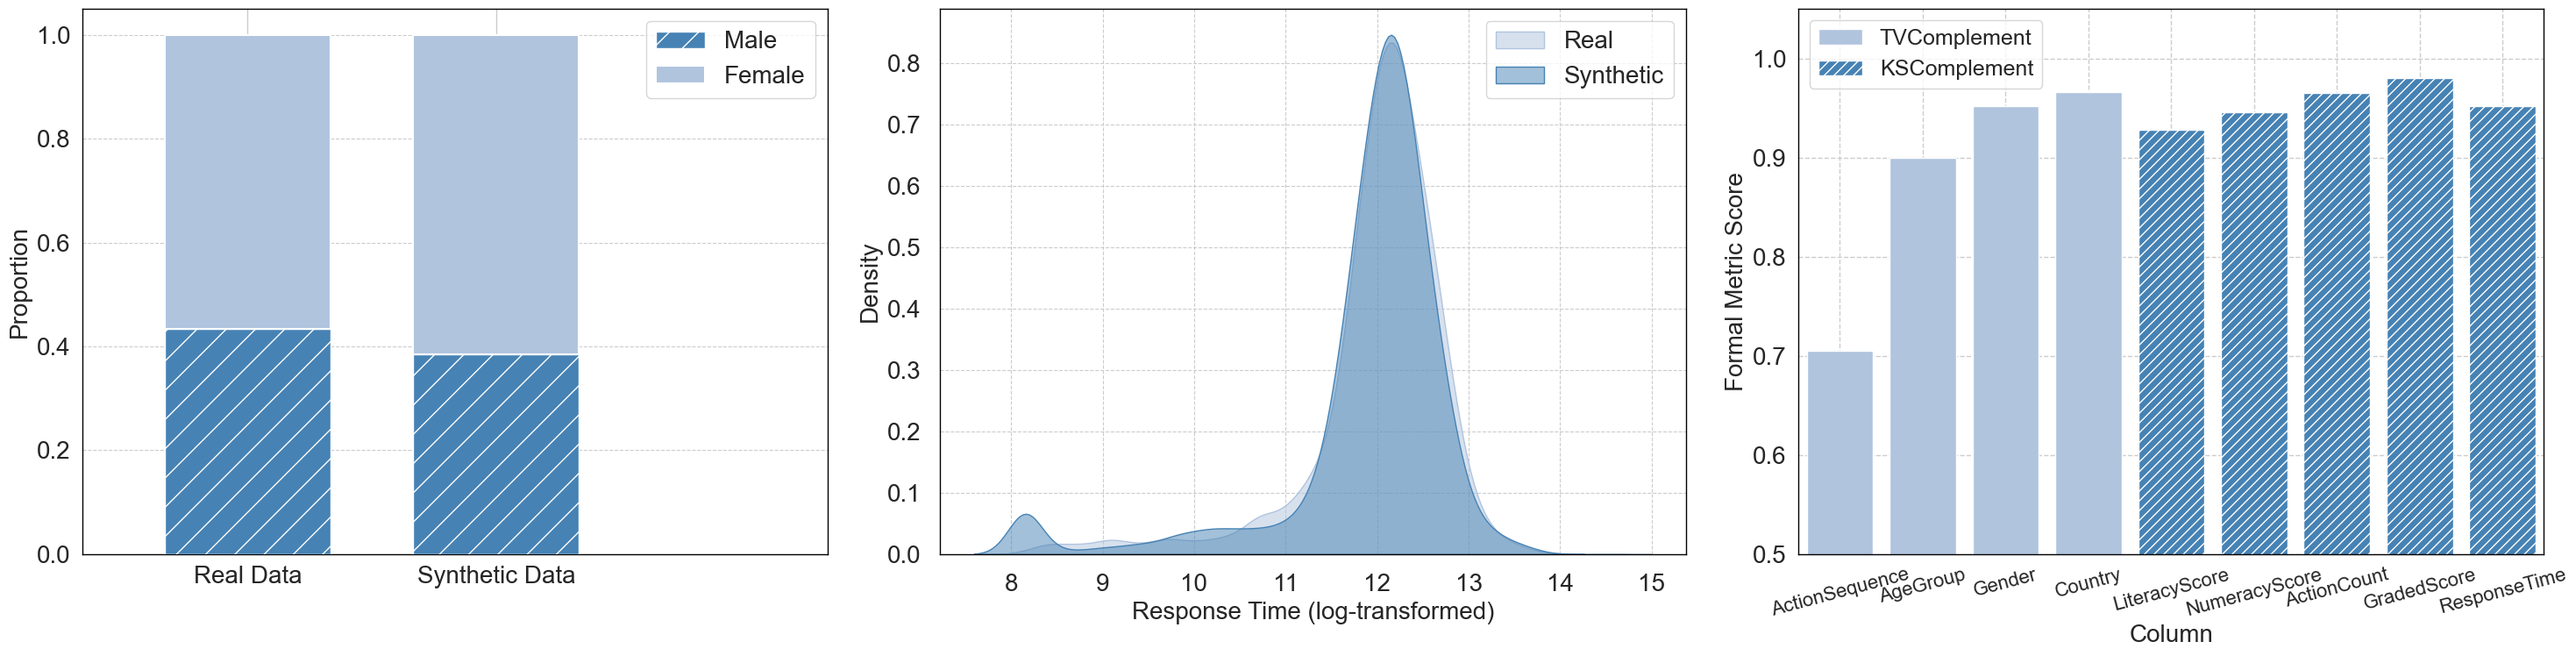

In [42]:
# =========================================================================
# 1) DATA PREPARATION (same as before)
# =========================================================================

font_size = 20

# ----------------------
# For the LEFT bar plot
# ----------------------
# Calculate normalized gender counts for real and synthetic data
real_counts = df['Gender'].value_counts(normalize=True)
synth_counts = synthetic_data['Gender'].value_counts(normalize=True)

male_prop = real_counts.get('Male', 0)
female_prop = real_counts.get('Female', 0)
real_props = [male_prop, female_prop]

male_prop_synth = synth_counts.get('Male', 0)
female_prop_synth = synth_counts.get('Female', 0)
synth_props = [male_prop_synth, female_prop_synth]

# x positions for the two bars (closer together)
x = [-0.05, 0.10]

# -----------------------
# For the MIDDLE plot (Density)
# -----------------------
# Extract the ResponseTime column from synthetic and real data
response_fake = pd.DataFrame({"ResponseTime": synthetic_data['ResponseTime'], "Dataset": "Synthetic"})
response_real = pd.DataFrame({"ResponseTime": transformed['ResponseTime'], "Dataset": "Real"})

# Log-transform the ResponseTime column
response_fake["ResponseTime"] = np.log1p(response_fake["ResponseTime"])
response_real["ResponseTime"] = np.log1p(response_real["ResponseTime"])

# -----------------------
# For the RIGHT bar plot
# -----------------------
# Suppose quality_deets1 has columns: Column, Metric, Score
# Define the custom order with "ActionSequence" as the first bar
custom_order = [
    "ActionSequence", "AgeGroup", "Gender", "Country", 
    "LiteracyScore", "NumeracyScore", "ActionCount", "GradedScore", "ResponseTime"
]

# Create a mapping from Column to Metric for later bar customization
metric_mapping = quality_deets1.set_index('Column')['Metric'].to_dict()

# =========================================================================
# 2) CREATE A SINGLE FIGURE WITH 3 SUBPLOTS (LEFT, MIDDLE, RIGHT)
# =========================================================================
fig, axes = plt.subplots(1, 3, figsize=(30, 8))  # adjust figsize as needed
ax_left, ax_middle, ax_right = axes

# =========================================================================
# LEFT SUBPLOT: Bar Plot (Gender Distribution)
# =========================================================================
ax_left.grid(axis='y', linestyle='--', linewidth=0.8, zorder=0)

# Plot the male part (base)
ax_left.bar(
    x, [real_props[0], synth_props[0]],
    color='steelblue', hatch='/', edgecolor='white',
    width=0.10, label='Male', zorder=3
)

# Plot the female part on top
ax_left.bar(
    x, [real_props[1], synth_props[1]],
    bottom=[real_props[0], synth_props[0]],
    color='lightsteelblue', width=0.10, linewidth=1.5,
    label='Female', zorder=3
)

# Customize x-axis, y-axis, etc.
ax_left.set_xticks(x)
ax_left.set_xticklabels(['Real Data', 'Synthetic Data'], fontsize=font_size)
ax_left.tick_params(axis='y', labelsize=font_size)
ax_left.set_ylabel("Proportion", fontsize=font_size)
ax_left.set_xlim(-0.15, 0.30)
ax_left.legend(fontsize=font_size, loc='upper right')

# Customize spines and grid
for spine in ax_left.spines.values():
    spine.set_edgecolor("black")
    spine.set_linewidth(1.0)

# =========================================================================
# MIDDLE SUBPLOT: Density Plot (Response Time)
# =========================================================================
# Optionally set a Seaborn theme
sns.set_theme(style="whitegrid", font_scale=2)

ax_middle.set_axisbelow(True)
ax_middle.grid(linestyle='--', linewidth=0.8)

# Plot the density curves
sns.kdeplot(
    data=response_real, x='ResponseTime', fill=True, alpha=0.5,
    label='Real', common_norm=False, color="lightsteelblue", ax=ax_middle
)
sns.kdeplot(
    data=response_fake, x='ResponseTime', fill=True, alpha=0.5,
    label='Synthetic', common_norm=False, color="steelblue", ax=ax_middle
)

# Customize spines, ticks, labels
for spine in ax_middle.spines.values():
    spine.set_edgecolor("black")
    spine.set_linewidth(1.0)

ax_middle.tick_params(axis='x', which='major', pad=10, labelsize=font_size)
ax_middle.tick_params(axis='y', which='major', pad=10, labelsize=font_size)
ax_middle.set_xlabel("Response Time (log-transformed)", fontsize=font_size)
ax_middle.set_ylabel("Density", fontsize=font_size)
ax_middle.legend(fontsize=font_size)

# =========================================================================
# RIGHT SUBPLOT: Bar Plot (Formal Metrics)
# =========================================================================
# Optionally set a Seaborn theme again (if you wish)
sns.set_theme(style="whitegrid", font_scale=2)

sns.barplot(
    data=quality_deets1, x='Column', y='Score', hue='Metric',
    palette='Set2', order=custom_order, ax=ax_right
)

# Set the y-axis and axis labels
ax_right.set_ylim(0.5, 1.05)
ax_right.set_xlabel("Column", fontsize=font_size)
ax_right.set_ylabel("Formal Metric Score", fontsize=font_size)
ax_right.set_xticklabels(ax_right.get_xticklabels(), rotation=15, fontsize=font_size-4)
ax_right.tick_params(axis='y', labelsize=font_size)

# Customize each bar based on its Metric
for patch, col in zip(ax_right.patches, custom_order):
    metric = metric_mapping[col]
    if metric == "TVComplement":
        patch.set_facecolor("lightsteelblue")
        patch.set_hatch("")  # no hatch
    elif metric == "KSComplement":
        patch.set_facecolor("steelblue")
        patch.set_hatch("///")

# Create custom legend handles so the legend shows correct colors/hatches
legend_elements = [
    Patch(facecolor="lightsteelblue", label="TVComplement", edgecolor="white"),
    Patch(facecolor="steelblue", hatch="///", label="KSComplement", edgecolor="white")
]
ax_right.legend(handles=legend_elements, fontsize=font_size-2)

# Customize spines and grid
for spine in ax_right.spines.values():
    spine.set_edgecolor("black")
    spine.set_linewidth(1.0)

ax_right.set_axisbelow(True)
ax_right.grid(True, linestyle='--', linewidth=1)

# =========================================================================
# 3) FINAL LAYOUT, SAVE (OPTIONAL), AND SHOW
# =========================================================================
plt.tight_layout()

if save_or_not:
    plt.savefig("../03_output_PAN/draft_plots/36_Quality_check_combined_2000epochs_three_combined.png", 
                dpi=600, bbox_inches='tight')

plt.show()

In [43]:
reversed_synthetic.head()

ID AgeGroup  Gender  ActionCount  \
0  0    45-49  Female           13   
1  1    50-54    Male           27   
2  2    16-19    Male           25   
3  3    35-39  Female            7   
4  4    20-24    Male           18   

                                      ActionSequence  GradedScore  \
0  START,COMBOBOX,COMBOBOX,BUTTON,CHECKBOX,BUTTON...            7   
1  START,COMBOBOX,COMBOBOX,TEXTLINK,TEXTLINK,TAB,...            1   
2  START,COMBOBOX,BUTTON,BUTTON,BUTTON,BUTTON,CHE...            1   
3  START,COMBOBOX,COMBOBOX,BUTTON,BUTTON,NEXT_INQ...            7   
4  START,TEXTLINK,TEXTLINK,CHECKBOX,BUTTON,BUTTON...            1   

   ResponseTime  LiteracyScore  NumeracyScore Country  
0         33985      279.01314      249.67735      UK  
1         97912      275.76138      288.58990      US  
2        134260      319.14865      352.22462      US  
3        213415      345.61646      325.87296      UK  
4        197916      319.14355      322.29320      US

In [44]:
# save the synthetic data
# reversed_synthetic.to_csv('../03_output_PAN/29_ctgan_synthetic_data_seed666_reversed_241215.csv', index=False)

In [45]:
# laod the synthetic data
# reversed_synthetic = pd.read_csv('../03_output_PAN/29_ctgan_synthetic_data_seed666_reversed_241215.csv')

In [46]:
reversed_synthetic.shape

(3254, 10)

### 2.3 Evaluate the action sequence using Ngram

#### 2.3.1 The method used in 20 file

In [47]:
# evaluate the data quality using ngram and rogue
from nltk.util import ngrams
from collections import Counter
from nltk.tokenize import word_tokenize

In [48]:
'''
# Define a function to compute n-gram precision
def ngram_precision(reference, candidate, n=1):
    ref_tokens = reference.split(',')
    cand_tokens = candidate.split(',')
    
    ref_ngrams = list(ngrams(ref_tokens, n))
    cand_ngrams = list(ngrams(cand_tokens, n))
    
    ref_set = set(ref_ngrams)
    cand_set = set(cand_ngrams)
    
    overlap = len(ref_set & cand_set)  # Intersection of n-grams
    precision = overlap / max(1, len(cand_set))  # Avoid division by zero
    return precision

# Evaluate unigram and bigram precision
unigram_scores = []
bigram_scores = []

for real_seq, synth_seq in zip(df['ActionSequence'], reversed_synthetic['ActionSequence']):
    unigram_scores.append(ngram_precision(real_seq, synth_seq, n=1))
    bigram_scores.append(ngram_precision(real_seq, synth_seq, n=2))

# Compute average scores
avg_unigram_precision = sum(unigram_scores) / len(unigram_scores)
avg_bigram_precision = sum(bigram_scores) / len(bigram_scores)

avg_unigram_precision, avg_bigram_precision
'''

"\n# Define a function to compute n-gram precision\ndef ngram_precision(reference, candidate, n=1):\n    ref_tokens = reference.split(',')\n    cand_tokens = candidate.split(',')\n    \n    ref_ngrams = list(ngrams(ref_tokens, n))\n    cand_ngrams = list(ngrams(cand_tokens, n))\n    \n    ref_set = set(ref_ngrams)\n    cand_set = set(cand_ngrams)\n    \n    overlap = len(ref_set & cand_set)  # Intersection of n-grams\n    precision = overlap / max(1, len(cand_set))  # Avoid division by zero\n    return precision\n\n# Evaluate unigram and bigram precision\nunigram_scores = []\nbigram_scores = []\n\nfor real_seq, synth_seq in zip(df['ActionSequence'], reversed_synthetic['ActionSequence']):\n    unigram_scores.append(ngram_precision(real_seq, synth_seq, n=1))\n    bigram_scores.append(ngram_precision(real_seq, synth_seq, n=2))\n\n# Compute average scores\navg_unigram_precision = sum(unigram_scores) / len(unigram_scores)\navg_bigram_precision = sum(bigram_scores) / len(bigram_scores)\n\nav

In [49]:
'''
# get the rogue score
from rouge_score import rouge_scorer

# Initialize ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Compute ROUGE scores for each sequence pair
rouge1_scores = []
rouge2_scores = []
rougeL_scores = []

for real_seq, synth_seq in zip(df['ActionSequence'], reversed_synthetic['ActionSequence']):
    scores = scorer.score(real_seq, synth_seq)
    rouge1_scores.append(scores['rouge1'].fmeasure)  # F1 score for ROUGE-1
    rouge2_scores.append(scores['rouge2'].fmeasure)  # F1 score for ROUGE-2
    rougeL_scores.append(scores['rougeL'].fmeasure)  # F1 score for ROUGE-L

# Calculate average ROUGE scores
avg_rouge1 = sum(rouge1_scores) / len(rouge1_scores)
avg_rouge2 = sum(rouge2_scores) / len(rouge2_scores)
avg_rougeL = sum(rougeL_scores) / len(rougeL_scores)

avg_rouge1, avg_rouge2, avg_rougeL
'''

"\n# get the rogue score\nfrom rouge_score import rouge_scorer\n\n# Initialize ROUGE scorer\nscorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)\n\n# Compute ROUGE scores for each sequence pair\nrouge1_scores = []\nrouge2_scores = []\nrougeL_scores = []\n\nfor real_seq, synth_seq in zip(df['ActionSequence'], reversed_synthetic['ActionSequence']):\n    scores = scorer.score(real_seq, synth_seq)\n    rouge1_scores.append(scores['rouge1'].fmeasure)  # F1 score for ROUGE-1\n    rouge2_scores.append(scores['rouge2'].fmeasure)  # F1 score for ROUGE-2\n    rougeL_scores.append(scores['rougeL'].fmeasure)  # F1 score for ROUGE-L\n\n# Calculate average ROUGE scores\navg_rouge1 = sum(rouge1_scores) / len(rouge1_scores)\navg_rouge2 = sum(rouge2_scores) / len(rouge2_scores)\navg_rougeL = sum(rougeL_scores) / len(rougeL_scores)\n\navg_rouge1, avg_rouge2, avg_rougeL\n"

#### 2.3.2 The method used in Dec

In [50]:
# convert the df into long format
# create a new df object to store the converted long format df
df_wide = df.copy()

df_long = pd.DataFrame(columns=df_wide.columns)

col_index = 0
for i in range(df_wide.shape[0]):

    # remove the START and END tokens
    #act_seq_i = df_wide["ActionSequence"][i].split(",")[1: -1]
    act_seq_i = df_wide["ActionSequence"][i].split(",")

    # get the length of the sequence
    act_seq_len = len(act_seq_i)

    # create the updated df_tempt to be concatenated to df_long
    df_tempt = pd.DataFrame([df_wide.iloc[i]] * act_seq_len, columns=df_wide.columns)

    # change  the df_tmp["ActionSeq_Collapsed"] values to be act_seq_i
    df_tempt["ActionSequence"] = act_seq_i

    # add a new column to df_tempt to store the sequence index
    df_tempt["Seq_Index"] = list(range(act_seq_len))

    # make the ith row of df_wide to repeat for act_seq_len times
    df_long = pd.concat([df_long, df_tempt], ignore_index=True)

# change the Seq_Index column to be integer
df_long["Seq_Index"] = df_long["Seq_Index"].astype(int)

C:\Users\grepa\AppData\Local\Temp\ipykernel_10692\3170807693.py:27: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



In [51]:
# change the fake data into long format
df_wide = reversed_synthetic.copy()

df_long_fake = pd.DataFrame(columns=df_wide.columns)    

for i in range(df_wide.shape[0]):
    act_seq_i = df_wide["ActionSequence"][i].split(",")
    act_seq_len = len(act_seq_i)
    df_tempt = pd.DataFrame([df_wide.iloc[i]] * act_seq_len, columns=df_wide.columns)
    df_tempt["ActionSequence"] = act_seq_i
    df_tempt["Seq_Index"] = list(range(act_seq_len))
    df_long_fake = pd.concat([df_long_fake, df_tempt], ignore_index=True)

df_long_fake["Seq_Index"] = df_long_fake["Seq_Index"].astype(int)

C:\Users\grepa\AppData\Local\Temp\ipykernel_10692\941164785.py:12: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



In [52]:
reversed_synthetic.head()

ID AgeGroup  Gender  ActionCount  \
0  0    45-49  Female           13   
1  1    50-54    Male           27   
2  2    16-19    Male           25   
3  3    35-39  Female            7   
4  4    20-24    Male           18   

                                      ActionSequence  GradedScore  \
0  START,COMBOBOX,COMBOBOX,BUTTON,CHECKBOX,BUTTON...            7   
1  START,COMBOBOX,COMBOBOX,TEXTLINK,TEXTLINK,TAB,...            1   
2  START,COMBOBOX,BUTTON,BUTTON,BUTTON,BUTTON,CHE...            1   
3  START,COMBOBOX,COMBOBOX,BUTTON,BUTTON,NEXT_INQ...            7   
4  START,TEXTLINK,TEXTLINK,CHECKBOX,BUTTON,BUTTON...            1   

   ResponseTime  LiteracyScore  NumeracyScore Country  
0         33985      279.01314      249.67735      UK  
1         97912      275.76138      288.58990      US  
2        134260      319.14865      352.22462      US  
3        213415      345.61646      325.87296      UK  
4        197916      319.14355      322.29320      US

In [53]:
df_long_fake.head()

ID AgeGroup  Gender ActionCount ActionSequence GradedScore ResponseTime  \
0  0    45-49  Female          13          START           7        33985   
1  0    45-49  Female          13       COMBOBOX           7        33985   
2  0    45-49  Female          13       COMBOBOX           7        33985   
3  0    45-49  Female          13         BUTTON           7        33985   
4  0    45-49  Female          13       CHECKBOX           7        33985   

   LiteracyScore  NumeracyScore Country  Seq_Index  
0      279.01314      249.67735      UK          0  
1      279.01314      249.67735      UK          1  
2      279.01314      249.67735      UK          2  
3      279.01314      249.67735      UK          3  
4      279.01314      249.67735      UK          4

#### 2.3.3 Check the token's freq

Check the action frequency between the real and fake data

In [54]:
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(df_long_fake)
# revise the metadata
metadata.update_column(
    column_name='GradedScore',
    sdtype='numerical'
)
metadata.update_column(
    column_name='ID',
    sdtype='id'
)
metadata

{
    "columns": {
        "ID": {
            "sdtype": "id"
        },
        "AgeGroup": {
            "sdtype": "categorical"
        },
        "Gender": {
            "sdtype": "categorical"
        },
        "ActionCount": {
            "sdtype": "numerical"
        },
        "ActionSequence": {
            "sdtype": "categorical"
        },
        "GradedScore": {
            "sdtype": "numerical"
        },
        "ResponseTime": {
            "sdtype": "numerical"
        },
        "LiteracyScore": {
            "sdtype": "numerical"
        },
        "NumeracyScore": {
            "sdtype": "numerical"
        },
        "Country": {
            "sdtype": "categorical"
        },
        "Seq_Index": {
            "sdtype": "numerical"
        }
    },
    "METADATA_SPEC_VERSION": "SINGLE_TABLE_V1"
}

In [55]:
# check the frequency of actions comparing the sd_back to the df_wide
action_freq = get_column_plot(real_data = df_long, synthetic_data = df_long_fake, column_name = 'ActionSequence', metadata=metadata)
action_freq.show(renderer='vscode')

Apply TVComplement on the `df_fake_long`'s action column

In [56]:
from sdmetrics.single_column import TVComplement

TVComplement.compute(real_data = df_long["ActionSequence"], synthetic_data = df_long_fake["ActionSequence"])

0.988271910641393

#### 2.3.4 Check the Ngram

In [57]:
from collections import Counter
from nltk import ngrams
from scipy.spatial.distance import jensenshannon
from functions import *

In [58]:
df.head()

ID AgeGroup  Gender  ActionCount          ActionSequence  GradedScore  \
0  4510    35-39    Male            3  START,NEXT_INQUIRY,END            0   
1  6757    60-65  Female            3  START,NEXT_INQUIRY,END            7   
2  1222    35-39    Male            3  START,NEXT_INQUIRY,END            7   
3  3334    55-59  Female            3  START,NEXT_INQUIRY,END            7   
4  6752    55-59  Female            3  START,NEXT_INQUIRY,END            7   

   ResponseTime  LiteracyScore  NumeracyScore Country  
0        370718      207.97638      179.39975      US  
1          9701      352.57521      320.61987      UK  
2         12320      205.31956      208.82338      UK  
3         11381      220.75269      210.86532      UK  
4          6044      227.52008      202.64041      UK

Here, I try to write a function to get the TVC-N score.

In [104]:
n_ = 1
# extract n-grams from the real and synthetic data
real_ngrams = extract_ngrams(df['ActionSequence'], n=n_)
synthetic_ngrams = extract_ngrams(reversed_synthetic['ActionSequence'], n=n_)
TVC_1 = TVC_N_v3(real_ngrams, synthetic_ngrams, top_n=10)
TVC_1

c:\Users\grepa\iCloudDrive\Desktop\PhD_Learning\Independent Studies\Process_Data_Project\02_code_PAN\functions.py:123: UserWarning:

This function is not the correct version. Use TVC_N_v4 instead.



0.989815146137206

In [108]:
TVC_1_test = TVC_N_v4(real_ngrams, synthetic_ngrams, top_n=10)
TVC_1_test

0.989815146137206

In [109]:
n_ = 2
# extract n-grams from the real and synthetic data
real_ngrams = extract_ngrams(df['ActionSequence'], n=n_)
synthetic_ngrams = extract_ngrams(reversed_synthetic['ActionSequence'], n=n_)
TVC_2 = TVC_N_v3(real_ngrams, synthetic_ngrams, top_n=10)
TVC_2

c:\Users\grepa\iCloudDrive\Desktop\PhD_Learning\Independent Studies\Process_Data_Project\02_code_PAN\functions.py:123: UserWarning:

This function is not the correct version. Use TVC_N_v4 instead.



0.9881347274865808

In [110]:
TVC_2_test = TVC_N_v4(real_ngrams, synthetic_ngrams, top_n=10)
TVC_2_test

0.9881347274865808

In [111]:
n_ = 3
# extract n-grams from the real and synthetic data
real_ngrams = extract_ngrams(df['ActionSequence'], n=n_)
synthetic_ngrams = extract_ngrams(reversed_synthetic['ActionSequence'], n=n_)
TVC_3 = TVC_N_v3(real_ngrams, synthetic_ngrams, top_n=10)
TVC_3

0.9845701954243361

In [112]:
TVC_3_test = TVC_N_v4(real_ngrams, synthetic_ngrams, top_n=10)
TVC_3_test

0.9845701954243361

In [63]:
# extract n-grams from the real and synthetic data
real_ngrams = extract_ngrams(df['ActionSequence'], n=1)
synthetic_ngrams = extract_ngrams(reversed_synthetic['ActionSequence'], n=1)

real_ngrams_norm = normalize(real_ngrams)
synthetic_ngrams_norm = normalize(synthetic_ngrams)

Counter(real_ngrams_norm)

Counter({('TAB',): 0.2425807168040865,
         ('BUTTON',): 0.226687210238472,
         ('COMBOBOX',): 0.1910968601649038,
         ('CHECKBOX',): 0.13451875294966825,
         ('NEXT_INQUIRY',): 0.04751395019571916,
         ('START',): 0.04516809638821798,
         ('END',): 0.04516809638821798,
         ('TEXTLINK',): 0.022334193942422476,
         ('TOOLBAR_HISTORY_BACK',): 0.01685128119707948,
         ('TOOLBAR',): 0.013825268593320563,
         ('END_CANCEL',): 0.00234585380750118,
         ('TOOLBAR_HISTORY_NEXT',): 0.0018877876794092334,
         ('TEXTBOX_USE',): 0.0018045029288470615,
         ('BOX_PRESS',): 0.0015546486771605451,
         ('TEXTBOX_ONFOCUS',): 0.0015268870936398211,
         ('TEXTBOX_KILLFOCUS',): 0.0015268870936398211,
         ('INVALID_TYPE',): 0.001360317592515477,
         ('MENU',): 0.0007218011715388246,
         ('GET_HELP',): 0.0006385164209766525,
         ('TOOLBAR_HISTORY_ADD',): 0.0005829932539352044,
         ('RESTART',): 0.000124927125843

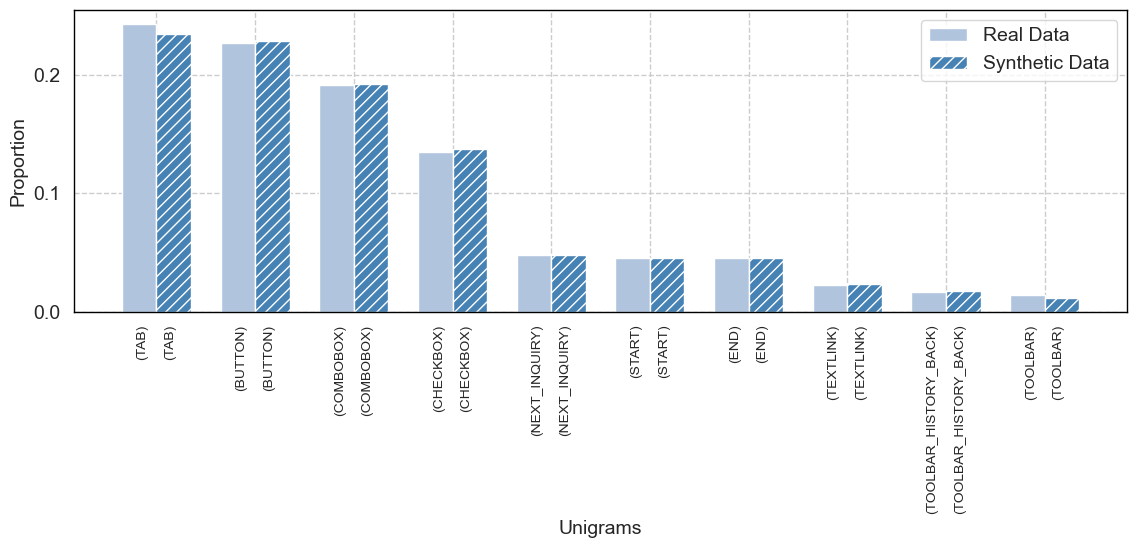

In [64]:
# Get top N N-grams for visualization
top_n = 10
real_top = Counter(real_ngrams_norm).most_common(top_n)
synthetic_top = Counter(synthetic_ngrams_norm).most_common(top_n)

# Convert N-grams (tuples) to strings for visualization
real_labels = [' '.join(ngram) for ngram, count in real_top]
real_counts = [count for ngram, count in real_top]

synthetic_labels = [' '.join(ngram) for ngram, count in synthetic_top]
synthetic_counts = [count for ngram, count in synthetic_top]

# Create the grouped bar plot
plt.figure(figsize=(12, 6))
x = np.arange(top_n)   # the label locations
width = 0.35           # the width of the bars

# Plot the bars side by side with the specified colors and hatch for synthetic data
plt.bar(x - width/2, real_counts, width=width, alpha=1, 
        label='Real Data', color='lightsteelblue')
plt.bar(x + width/2, synthetic_counts, width=width, alpha=1, 
        label='Synthetic Data', color='steelblue', hatch='///')

# Create combined labels showing both real and synthetic n-grams
combined_labels = [f"({r})\n\n({s})" for r, s in zip(real_labels, synthetic_labels)]
plt.xticks(x, combined_labels, rotation=90, fontsize=10)
plt.yticks(fontsize=14)

# Add axis labels and title
plt.xlabel("Unigrams", fontsize=14)
plt.ylabel("Proportion", fontsize=14)
# plt.title(f"Top {top_n} Unigrams using CTGAN")
plt.grid(True, linestyle='--', linewidth=1)
# Update legend
plt.legend(fontsize = 14)

# Adjust layout to avoid clipping of labels
plt.tight_layout()
# Add a black frame around the plot by customizing the axes spines
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1)

if save_or_not:
    plt.savefig("../03_output_PAN/draft_plots/36_Ngrams_TVC_1_check.png", dpi=600, bbox_inches='tight')

plt.show()


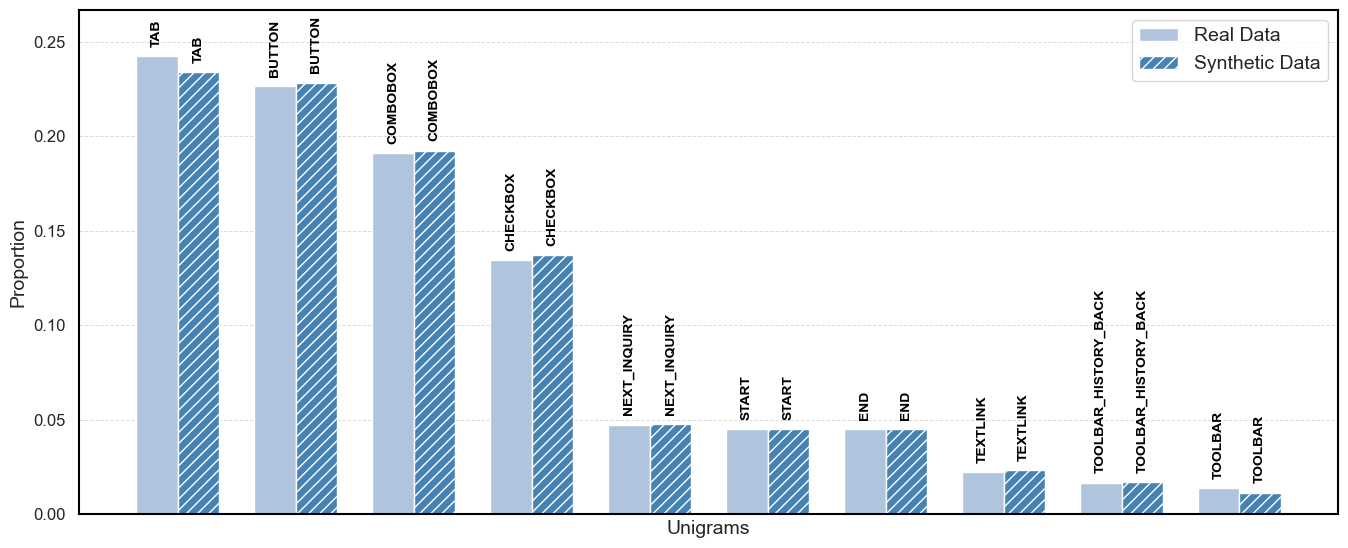

In [65]:
# Get top N N-grams for visualization
top_n = 10
real_top = Counter(real_ngrams_norm).most_common(top_n)
synthetic_top = Counter(synthetic_ngrams_norm).most_common(top_n)

# Convert N-grams (tuples) to strings for visualization
real_labels = [' '.join(ngram) for ngram, count in real_top]
real_counts = [count for ngram, count in real_top]

synthetic_labels = [' '.join(ngram) for ngram, count in synthetic_top]
synthetic_counts = [count for ngram, count in synthetic_top]

# Create the grouped bar plot
plt.figure(figsize=(14, 6))  # Increase width for better spacing
x = np.arange(top_n)   # the label locations
width = 0.35           # the width of the bars
offset = max(real_counts + synthetic_counts) * 0.02  # Dynamic offset for spacing

# Plot the bars side by side with the specified colors and hatch for synthetic data
bars_real = plt.bar(x - width/2, real_counts, width=width, alpha=1, 
                    label='Real Data', color='lightsteelblue')
bars_synthetic = plt.bar(x + width/2, synthetic_counts, width=width, alpha=1, 
                         label='Synthetic Data', color='steelblue', hatch='///')

# Remove xticks
plt.xticks([])
plt.ylim(0, max(real_counts + synthetic_counts) * 1.1)  # Adjust y-axis limits for better visibility

# Add text labels **above** the bars with 90-degree rotation
for bar, real_label in zip(bars_real, real_labels):
    plt.text(bar.get_x() + bar.get_width() / 2,  # Centering label
             bar.get_height() + offset,  # Positioning above the bar
             real_label, 
             ha='center', va='bottom', rotation=90, fontsize=10, color='black', fontweight='bold')

for bar, synthetic_label in zip(bars_synthetic, synthetic_labels):
    plt.text(bar.get_x() + bar.get_width() / 2,  
             bar.get_height() + offset,  
             synthetic_label, 
             ha='center', va='bottom', rotation=90, fontsize=10, color='black', fontweight='bold')

# Adjust y-axis tick font size
plt.yticks(fontsize=12)

# Add axis labels
plt.xlabel("Unigrams", fontsize=14)
plt.ylabel("Proportion", fontsize=14)
plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)  # Lighter grid lines for readability

# Update legend with a larger font size
plt.legend(fontsize=14)

# Adjust layout to avoid clipping
plt.tight_layout()

# Add a black frame around the plot
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1.5)

# Save the figure if needed
if save_or_not:
    plt.savefig("../03_output_PAN/draft_plots/36_Ngrams_TVC_1_check.png", dpi=600, bbox_inches='tight')

plt.show()


In [66]:
real_values = []
synthetic_values = []
for key in set(real_ngrams_norm.keys()).union(synthetic_ngrams_norm.keys()):
    real_values.append(real_ngrams_norm.get(key, 0))
    synthetic_values.append(synthetic_ngrams_norm.get(key, 0))

js_divergence = jensenshannon(real_values, synthetic_values)
print(f"Jensen-Shannon Divergence: {js_divergence}")

Jensen-Shannon Divergence: 0.019782705547069995


#### 2.3.5 N=2

In [67]:
# extract n-grams from the real and synthetic data
real_ngrams = extract_ngrams(df['ActionSequence'], n=2)
synthetic_ngrams = extract_ngrams(reversed_synthetic['ActionSequence'], n=2)

real_ngrams_norm = normalize(real_ngrams)
synthetic_ngrams_norm = normalize(synthetic_ngrams)

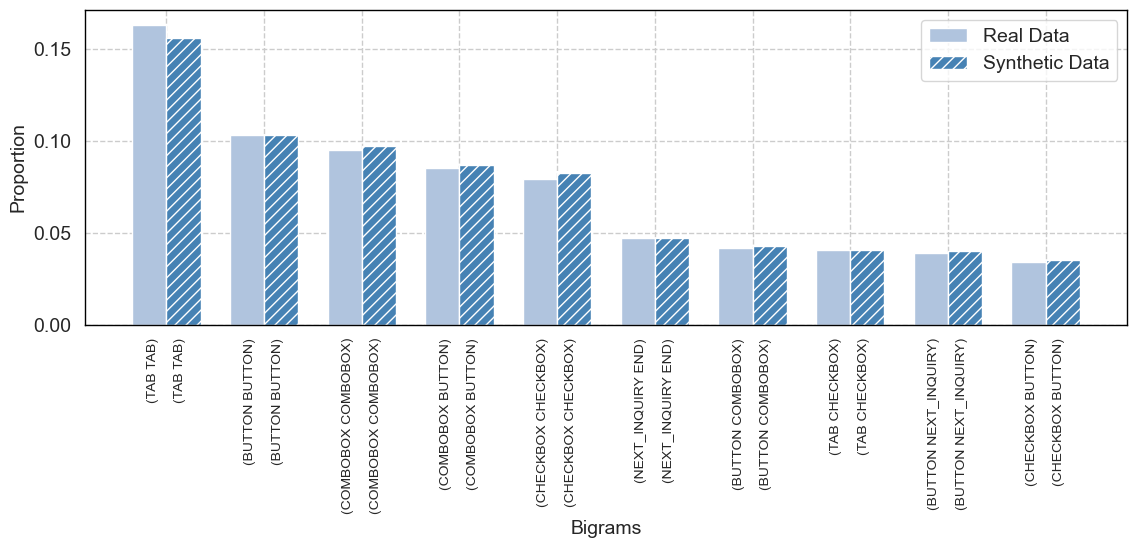

In [68]:
# Get top N N-grams for visualization
top_n = 10
real_top = Counter(real_ngrams_norm).most_common(top_n)
synthetic_top = Counter(synthetic_ngrams_norm).most_common(top_n)

# Convert N-grams (tuples) to strings for visualization
real_labels = [' '.join(ngram) for ngram, count in real_top]
real_counts = [count for ngram, count in real_top]

synthetic_labels = [' '.join(ngram) for ngram, count in synthetic_top]
synthetic_counts = [count for ngram, count in synthetic_top]

# Create the grouped bar plot
plt.figure(figsize=(12, 6))
x = np.arange(top_n)   # the label locations
width = 0.35           # the width of the bars

# Plot the bars side by side with the specified colors and hatch for synthetic data
plt.bar(x - width/2, real_counts, width=width, alpha=1, 
        label='Real Data', color='lightsteelblue')
plt.bar(x + width/2, synthetic_counts, width=width, alpha=1, 
        label='Synthetic Data', color='steelblue', hatch='///')

# Create combined labels showing both real and synthetic n-grams
combined_labels = [f"({r})\n\n({s})" for r, s in zip(real_labels, synthetic_labels)]
plt.xticks(x, combined_labels, rotation=90, fontsize=10)
plt.yticks(fontsize=14)

# Add axis labels and title
plt.xlabel("Bigrams", fontsize=14)
plt.ylabel("Proportion", fontsize=14)
# plt.title(f"Top {top_n} Unigrams using CTGAN")
plt.grid(True, linestyle='--', linewidth=1)
# Update legend
plt.legend(fontsize = 14)

# Adjust layout to avoid clipping of labels
plt.tight_layout()
# Add a black frame around the plot by customizing the axes spines
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1)

if save_or_not:
    plt.savefig("../03_output_PAN/draft_plots/36_Ngrams_TVC_2_check.png", dpi=600, bbox_inches='tight')

plt.show()


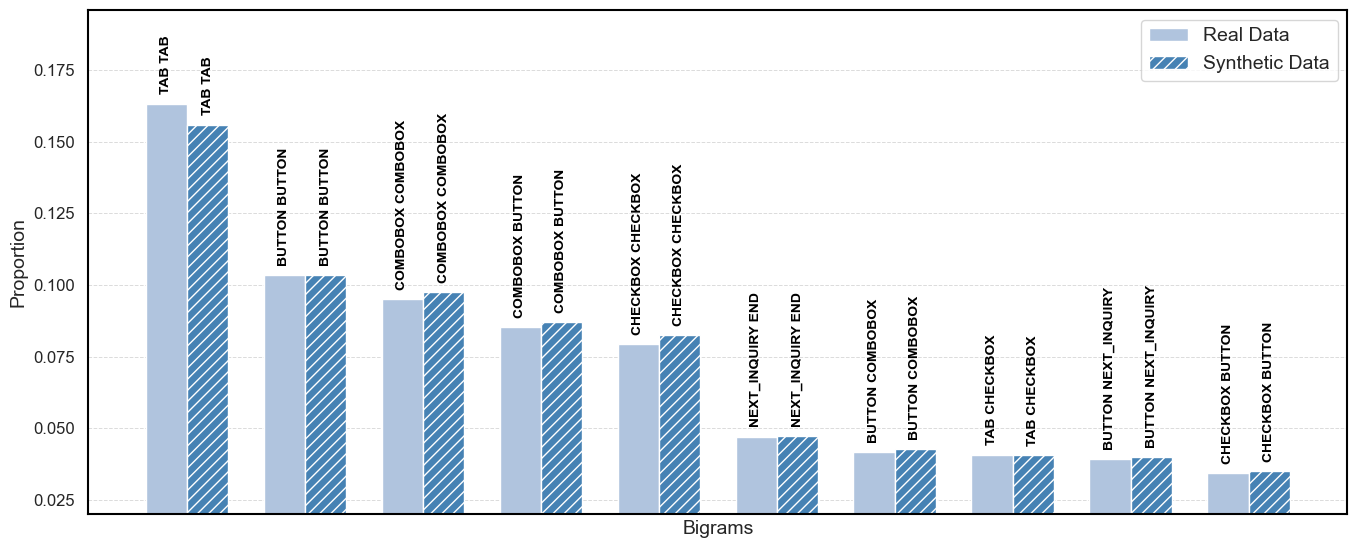

In [69]:
# Get top N N-grams for visualization
top_n = 10
real_top = Counter(real_ngrams_norm).most_common(top_n)
synthetic_top = Counter(synthetic_ngrams_norm).most_common(top_n)

# Convert N-grams (tuples) to strings for visualization
real_labels = [' '.join(ngram) for ngram, count in real_top]
real_counts = [count for ngram, count in real_top]

synthetic_labels = [' '.join(ngram) for ngram, count in synthetic_top]
synthetic_counts = [count for ngram, count in synthetic_top]

# Create the grouped bar plot
plt.figure(figsize=(14, 6))  # Increase width for better spacing
x = np.arange(top_n)   # the label locations
width = 0.35           # the width of the bars
offset = max(real_counts + synthetic_counts) * 0.02  # Dynamic offset for spacing

# Plot the bars side by side with the specified colors and hatch for synthetic data
bars_real = plt.bar(x - width/2, real_counts, width=width, alpha=1, 
                    label='Real Data', color='lightsteelblue')
bars_synthetic = plt.bar(x + width/2, synthetic_counts, width=width, alpha=1, 
                         label='Synthetic Data', color='steelblue', hatch='///')

# Remove xticks
plt.xticks([])
plt.ylim(0.02, max(real_counts + synthetic_counts) * 1.2)  # Adjust y-axis limits for better visibility

# Add text labels **above** the bars with 90-degree rotation
for bar, real_label in zip(bars_real, real_labels):
    plt.text(bar.get_x() + bar.get_width() / 2,  # Centering label
             bar.get_height() + offset,  # Positioning above the bar
             real_label, 
             ha='center', va='bottom', rotation=90, fontsize=10, color='black', fontweight='bold')

for bar, synthetic_label in zip(bars_synthetic, synthetic_labels):
    plt.text(bar.get_x() + bar.get_width() / 2,  
             bar.get_height() + offset,  
             synthetic_label, 
             ha='center', va='bottom', rotation=90, fontsize=10, color='black', fontweight='bold')

# Adjust y-axis tick font size
plt.yticks(fontsize=12)

# Add axis labels
plt.xlabel("Bigrams", fontsize=14)
plt.ylabel("Proportion", fontsize=14)
plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)  # Lighter grid lines for readability

# Update legend with a larger font size
plt.legend(fontsize=14)

# Adjust layout to avoid clipping
plt.tight_layout()

# Add a black frame around the plot
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1.5)

# Save the figure if needed
if save_or_not:
    plt.savefig("../03_output_PAN/draft_plots/36_Ngrams_TVC_1_check.png", dpi=600, bbox_inches='tight')

plt.show()


In [70]:
real_values = []
synthetic_values = []
for key in set(real_ngrams_norm.keys()).union(synthetic_ngrams_norm.keys()):
    real_values.append(real_ngrams_norm.get(key, 0))
    synthetic_values.append(synthetic_ngrams_norm.get(key, 0))

js_divergence = jensenshannon(real_values, synthetic_values)
print(f"Jensen-Shannon Divergence: {js_divergence}")

Jensen-Shannon Divergence: 0.04188613084703378


#### 2.2.6 N=3

In [71]:
# extract n-grams from the real and synthetic data
real_ngrams = extract_ngrams(df['ActionSequence'], n=3)
synthetic_ngrams = extract_ngrams(reversed_synthetic['ActionSequence'], n=3)

real_ngrams_norm = normalize(real_ngrams)
synthetic_ngrams_norm = normalize(synthetic_ngrams)

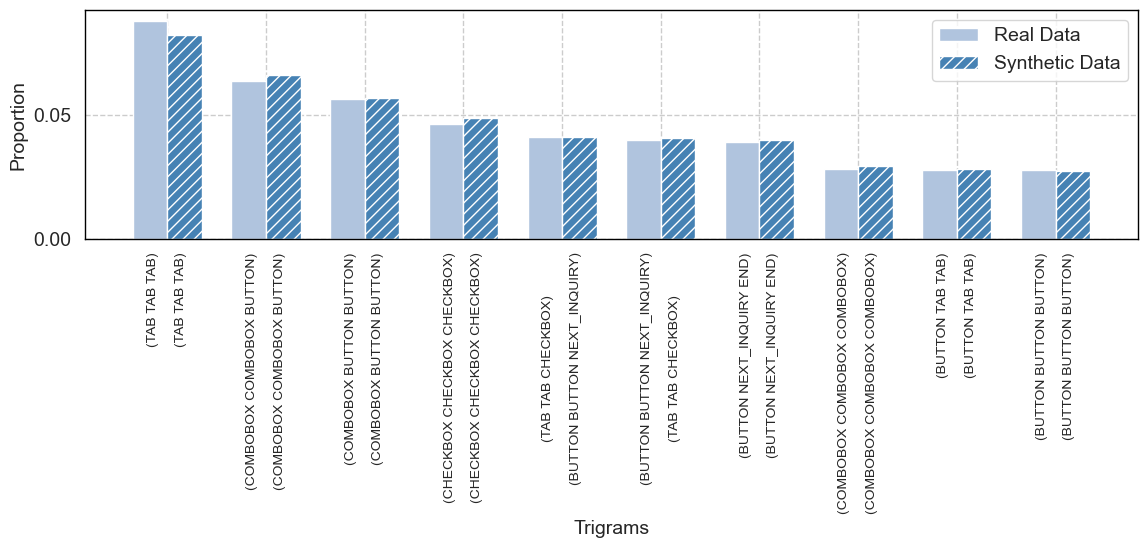

In [72]:
# Get top N N-grams for visualization
top_n = 10
real_top = Counter(real_ngrams_norm).most_common(top_n)
synthetic_top = Counter(synthetic_ngrams_norm).most_common(top_n)

# Convert N-grams (tuples) to strings for visualization
real_labels = [' '.join(ngram) for ngram, count in real_top]
real_counts = [count for ngram, count in real_top]

synthetic_labels = [' '.join(ngram) for ngram, count in synthetic_top]
synthetic_counts = [count for ngram, count in synthetic_top]

# Create the grouped bar plot
plt.figure(figsize=(12, 6))
x = np.arange(top_n)   # the label locations
width = 0.35           # the width of the bars

# Plot the bars side by side with the specified colors and hatch for synthetic data
plt.bar(x - width/2, real_counts, width=width, alpha=1, 
        label='Real Data', color='lightsteelblue')
plt.bar(x + width/2, synthetic_counts, width=width, alpha=1, 
        label='Synthetic Data', color='steelblue', hatch='///')

# Create combined labels showing both real and synthetic n-grams
combined_labels = [f"({r})\n\n({s})" for r, s in zip(real_labels, synthetic_labels)]
plt.xticks(x, combined_labels, rotation=90, fontsize=10)
plt.yticks(fontsize=14)

# Add axis labels and title
plt.xlabel("Trigrams", fontsize=14)
plt.ylabel("Proportion", fontsize=14)
# plt.title(f"Top {top_n} Unigrams using CTGAN")
plt.grid(True, linestyle='--', linewidth=1)
# Update legend
plt.legend(fontsize = 14)

# Adjust layout to avoid clipping of labels
plt.tight_layout()
# Add a black frame around the plot by customizing the axes spines
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1)

if save_or_not:
    plt.savefig("../03_output_PAN/draft_plots/36_Ngrams_TVC_2_check.png", dpi=600, bbox_inches='tight')

plt.show()


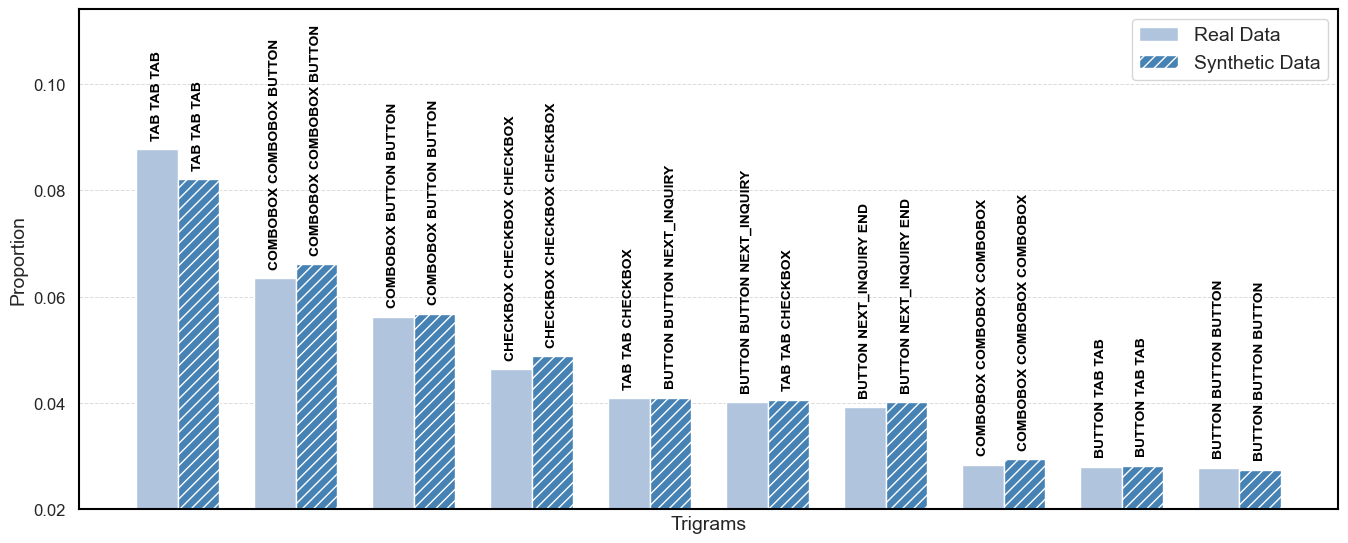

In [73]:
# Get top N N-grams for visualization
top_n = 10
real_top = Counter(real_ngrams_norm).most_common(top_n)
synthetic_top = Counter(synthetic_ngrams_norm).most_common(top_n)

# Convert N-grams (tuples) to strings for visualization
real_labels = [' '.join(ngram) for ngram, count in real_top]
real_counts = [count for ngram, count in real_top]

synthetic_labels = [' '.join(ngram) for ngram, count in synthetic_top]
synthetic_counts = [count for ngram, count in synthetic_top]

# Create the grouped bar plot
plt.figure(figsize=(14, 6))  # Increase width for better spacing
x = np.arange(top_n)   # the label locations
width = 0.35           # the width of the bars
offset = max(real_counts + synthetic_counts) * 0.02  # Dynamic offset for spacing

# Plot the bars side by side with the specified colors and hatch for synthetic data
bars_real = plt.bar(x - width/2, real_counts, width=width, alpha=1, 
                    label='Real Data', color='lightsteelblue')
bars_synthetic = plt.bar(x + width/2, synthetic_counts, width=width, alpha=1, 
                         label='Synthetic Data', color='steelblue', hatch='///')

# Remove xticks
plt.xticks([])
plt.ylim(0.02, max(real_counts + synthetic_counts) * 1.3)  # Adjust y-axis limits for better visibility

# Add text labels **above** the bars with 90-degree rotation
for bar, real_label in zip(bars_real, real_labels):
    plt.text(bar.get_x() + bar.get_width() / 2,  # Centering label
             bar.get_height() + offset,  # Positioning above the bar
             real_label, 
             ha='center', va='bottom', rotation=90, fontsize=10, color='black', fontweight='bold')

for bar, synthetic_label in zip(bars_synthetic, synthetic_labels):
    plt.text(bar.get_x() + bar.get_width() / 2,  
             bar.get_height() + offset,  
             synthetic_label, 
             ha='center', va='bottom', rotation=90, fontsize=10, color='black', fontweight='bold')

# Adjust y-axis tick font size
plt.yticks(fontsize=12)

# Add axis labels
plt.xlabel("Trigrams", fontsize=14)
plt.ylabel("Proportion", fontsize=14)
plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)  # Lighter grid lines for readability

# Update legend with a larger font size
plt.legend(fontsize=14)

# Adjust layout to avoid clipping
plt.tight_layout()

# Add a black frame around the plot
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1.5)

# Save the figure if needed
if save_or_not:
    plt.savefig("../03_output_PAN/draft_plots/36_Ngrams_TVC_1_check.png", dpi=600, bbox_inches='tight')

plt.show()


In [74]:
real_values = []
synthetic_values = []
for key in set(real_ngrams_norm.keys()).union(synthetic_ngrams_norm.keys()):
    real_values.append(real_ngrams_norm.get(key, 0))
    synthetic_values.append(synthetic_ngrams_norm.get(key, 0))

js_divergence = jensenshannon(real_values, synthetic_values)
print(f"Jensen-Shannon Divergence: {js_divergence}")

Jensen-Shannon Divergence: 0.07044892419536489


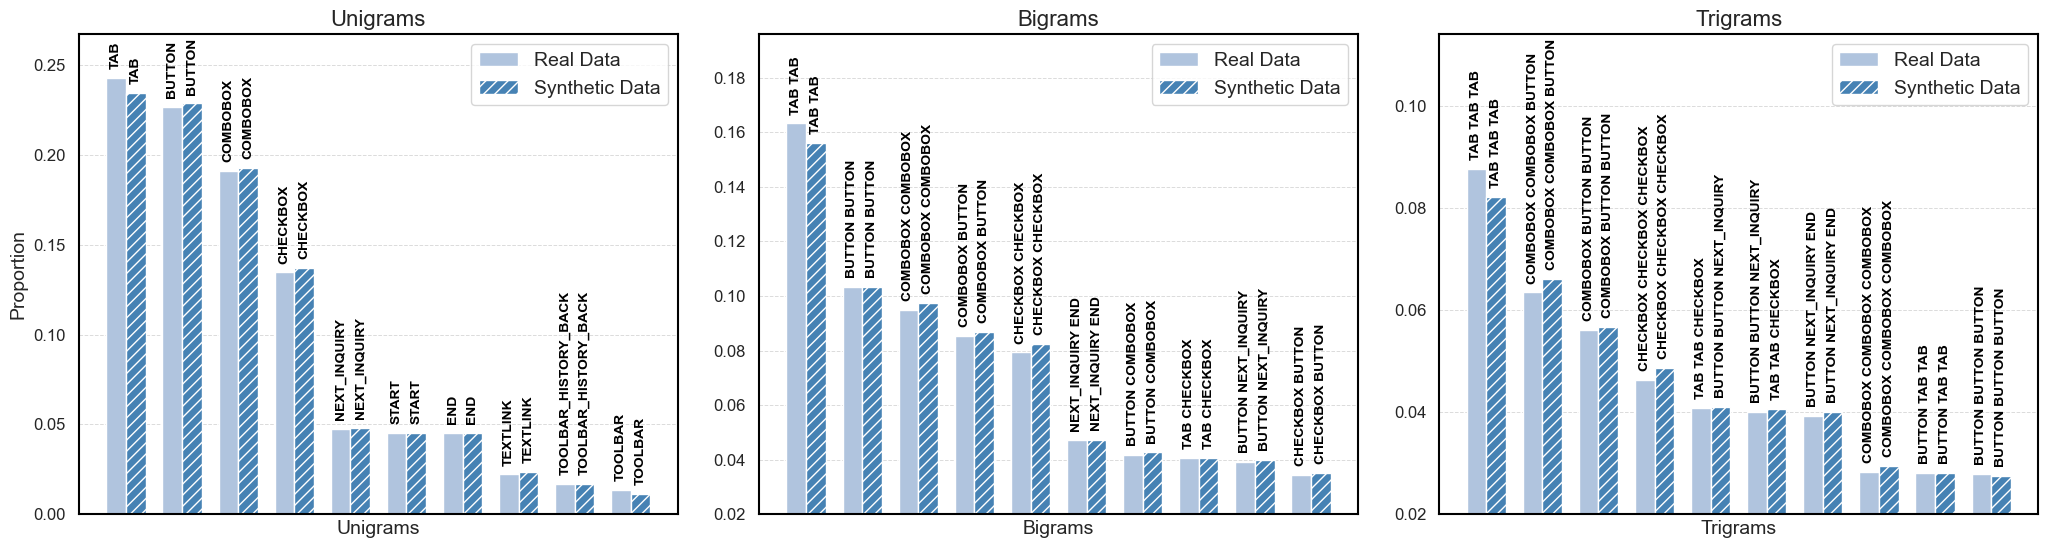

In [75]:
# Create a figure with 3 subplots (one per n-gram order)
fig, axes = plt.subplots(1, 3, figsize=(21, 6))
ngram_types = [1, 2, 3]
titles = ["Unigrams", "Bigrams", "Trigrams"]

for idx, n in enumerate(ngram_types):
    ax = axes[idx]
    
    # Extract and normalize n-grams from real and synthetic data
    real_ngrams = extract_ngrams(df['ActionSequence'], n=n)
    synthetic_ngrams = extract_ngrams(reversed_synthetic['ActionSequence'], n=n)
    
    real_ngrams_norm = normalize(real_ngrams)
    synthetic_ngrams_norm = normalize(synthetic_ngrams)
    
    # Get top N n-grams for visualization
    top_n = 10
    real_top = Counter(real_ngrams_norm).most_common(top_n)
    synthetic_top = Counter(synthetic_ngrams_norm).most_common(top_n)
    
    # Convert n-gram tuples to strings for labeling
    real_labels = [' '.join(ngram) for ngram, count in real_top]
    real_counts = [count for ngram, count in real_top]
    
    synthetic_labels = [' '.join(ngram) for ngram, count in synthetic_top]
    synthetic_counts = [count for ngram, count in synthetic_top]
    
    # Create the grouped bar plot
    x = np.arange(top_n)  # positions for bars
    width = 0.35
    offset = max(real_counts + synthetic_counts) * 0.02  # Dynamic offset for text
    
    bars_real = ax.bar(x - width/2, real_counts, width=width, alpha=1, 
                       label='Real Data', color='lightsteelblue')
    bars_synthetic = ax.bar(x + width/2, synthetic_counts, width=width, alpha=1, 
                            label='Synthetic Data', color='steelblue', hatch='///')
    
    # Remove x-axis ticks
    ax.set_xticks([])
    
    # Set dynamic y-axis limits based on n-gram type (as in your original code)
    y_max = max(real_counts + synthetic_counts)
    if n == 1:
        lower_lim, mult = 0, 1.1
    elif n == 2:
        lower_lim, mult = 0.02, 1.2
    elif n == 3:
        lower_lim, mult = 0.02, 1.3
    ax.set_ylim(lower_lim, y_max * mult)
    
    # Add text labels above each bar with 90-degree rotation
    for bar, label in zip(bars_real, real_labels):
        ax.text(bar.get_x() + bar.get_width() / 2,
                bar.get_height() + offset,
                label,
                ha='center', va='bottom', rotation=90,
                fontsize=10, color='black', fontweight='bold')
    for bar, label in zip(bars_synthetic, synthetic_labels):
        ax.text(bar.get_x() + bar.get_width() / 2,
                bar.get_height() + offset,
                label,
                ha='center', va='bottom', rotation=90,
                fontsize=10, color='black', fontweight='bold')
    
    # Set y-axis tick label size
    ax.tick_params(axis='y', labelsize=12)
    
    # Label the axes (using the title to indicate n-gram type)
    ax.set_title(titles[idx], fontsize=16)
    # Only add a y-axis label to the leftmost subplot to avoid redundancy
    if idx == 0:
        ax.set_ylabel("Proportion", fontsize=14)
    ax.set_xlabel(titles[idx], fontsize=14)
    
    # Add grid lines for readability
    ax.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)
    
    # Add the legend (you can choose to show it only on one subplot if preferred)
    ax.legend(fontsize=14)
    
    # Add a black frame around each subplot
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1.5)

# Adjust layout to avoid overlapping elements
plt.tight_layout()

# Save the figure if needed
if save_or_not:
    plt.savefig("../03_output_PAN/draft_plots/36_Ngrams_TVC_1_check.png", dpi=600, bbox_inches='tight')

plt.show()


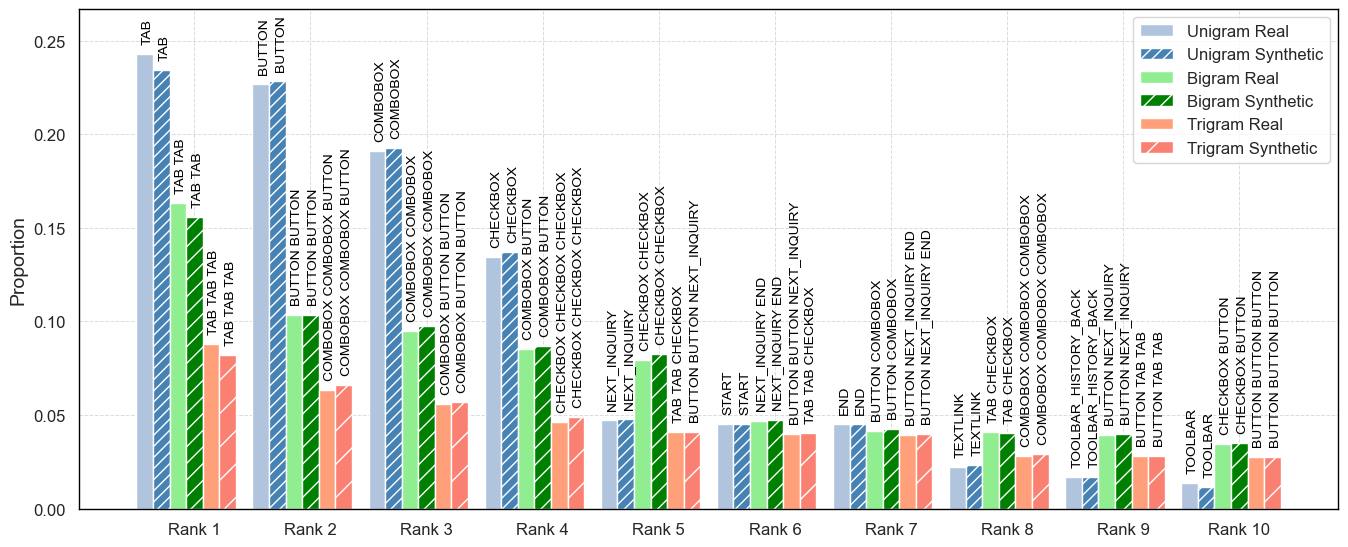

In [76]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from matplotlib.patches import Patch

# -----------------------
# Parameters for plotting
# -----------------------
top_n = 10          # Number of top n-grams to display per n-gram type
bar_width = 0.5     # Width of each bar
n_types = 3         # We have three types: unigram, bigram, trigram
cluster_width = n_types * 2 * bar_width  # Each type contributes 2 bars (Real and Synthetic)
gap = 0.5           # Gap between ranking groups

# -----------------------
# Define color pairs for each n-gram setting (index 0: unigram, 1: bigram, 2: trigram)
# -----------------------
color_pairs = {
    0: {"real": "lightsteelblue", "synthetic": "steelblue"},
    1: {"real": "lightgreen",    "synthetic": "green"},
    2: {"real": "lightsalmon",   "synthetic": "salmon"}
}

hatch_pairs = {
    0: {"real": "", "synthetic": "///"},
    1: {"real": "", "synthetic": "//"},
    2: {"real": "", "synthetic": "/"}
}

# -----------------------
# Precompute data for each n-gram type
# -----------------------
# We'll store the top counts and labels for real and synthetic data for n = 1,2,3.
data = {}
for n in [1, 2, 3]:
    # Extract n-grams from the real and synthetic data
    real_ngrams = extract_ngrams(df['ActionSequence'], n=n)
    synthetic_ngrams = extract_ngrams(reversed_synthetic['ActionSequence'], n=n)
    
    # Normalize the n-gram frequencies
    real_ngrams_norm = normalize(real_ngrams)
    synthetic_ngrams_norm = normalize(synthetic_ngrams)
    
    # Get top N n-grams (most common)
    real_top = Counter(real_ngrams_norm).most_common(top_n)
    synthetic_top = Counter(synthetic_ngrams_norm).most_common(top_n)
    
    # Convert tuple n-grams to string labels for plotting
    labels_real = [' '.join(ngram) for ngram, count in real_top]
    counts_real = [count for ngram, count in real_top]
    
    labels_synth = [' '.join(ngram) for ngram, count in synthetic_top]
    counts_synth = [count for ngram, count in synthetic_top]
    
    data[n] = {
        'labels_real': labels_real,
        'counts_real': counts_real,
        'labels_synth': labels_synth,
        'counts_synth': counts_synth
    }

# -----------------------
# Determine y-axis maximum (for consistent scaling) and text offset
# -----------------------
all_counts = []
for n in [1, 2, 3]:
    all_counts.extend(data[n]['counts_real'])
    all_counts.extend(data[n]['counts_synth'])
ymax = max(all_counts) * 1.1
offset = ymax * 0.02  # Vertical offset for text labels

# -----------------------
# Create the figure and axis
# -----------------------
fig, ax = plt.subplots(figsize=(14, 6))

# Compute group (ranking) centers.
# We have top_n groups; each group will host a cluster of 6 bars.
group_centers = []
for i in range(top_n):
    # The group starts at i*(cluster_width + gap) and has width = cluster_width;
    # take the center as:
    group_center = i * (cluster_width + gap) + (cluster_width + gap) / 2
    group_centers.append(group_center)

# -----------------------
# Plot bars for each ranking group and each n-gram type
# -----------------------
# Order the n-gram types as: 1 (unigrams), 2 (bigrams), 3 (trigrams)
for i in range(top_n):
    group_center = group_centers[i]
    # For each n-gram type j (0: unigram, 1: bigram, 2: trigram)
    for j, n in enumerate([1, 2, 3]):
        # Compute the starting x-position for this n-gram type within the group
        # The cluster has total width = cluster_width; we start at the left edge:
        slot_start = group_center - cluster_width / 2 + j * (2 * bar_width)
        
        # Select the color pair for this setting
        real_color = color_pairs[j]["real"]
        synth_color = color_pairs[j]["synthetic"]
        
        # --- Real Data Bar ---
        pos_real = slot_start  # left half of the slot
        height_real = data[n]['counts_real'][i]
        ax.bar(pos_real, height_real, width=bar_width, color=real_color)
        ax.text(pos_real+ bar_width/5, height_real + offset, data[n]['labels_real'][i], # + bar_width/4
                ha='center', va='bottom', rotation=90, fontsize=10,
                color='black' 
                #fontweight='bold'
                )
        
        # --- Synthetic Data Bar ---
        pos_synth = slot_start + bar_width  # right half of the slot
        height_synth = data[n]['counts_synth'][i]
        ax.bar(pos_synth, height_synth, width=bar_width, color=synth_color, hatch=hatch_pairs[j]["synthetic"])
        ax.text(pos_synth +bar_width/5, height_synth + offset, data[n]['labels_synth'][i],
                ha='center', va='bottom', rotation=90, fontsize=10,
                color='black' 
                #fontweight='bold'
                )

# -----------------------
# Finalize the plot: x-axis, grid, legend, etc.
# -----------------------
# Set x-axis ticks at the center of each ranking group and label them by rank.
ax.set_xticks(group_centers)
ax.set_xticklabels([f"Rank {i+1}" for i in range(top_n)], fontsize=12)
ax.tick_params(axis='y', labelsize=12)


ax.set_ylim(0, ymax)
ax.set_ylabel("Proportion", fontsize=14)
# ax.set_xlabel("Ranking of N-grams (Aggregated over Unigrams, Bigrams, Trigrams)", fontsize=14)
ax.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)

# Create custom legend handles for each n-gram type and data type
legend_handles = [
    Patch(facecolor=color_pairs[0]["real"], label="Unigram Real"),
    Patch(facecolor=color_pairs[0]["synthetic"], hatch='///', label="Unigram Synthetic"),
    Patch(facecolor=color_pairs[1]["real"], label="Bigram Real"),
    Patch(facecolor=color_pairs[1]["synthetic"], hatch='//', label="Bigram Synthetic"),
    Patch(facecolor=color_pairs[2]["real"], label="Trigram Real"),
    Patch(facecolor=color_pairs[2]["synthetic"], hatch='/', label="Trigram Synthetic")
]
ax.legend(handles=legend_handles, fontsize=12)

# Add a black frame around the plot
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1.0)

plt.tight_layout()

# Save the figure if needed
if save_or_not:
    plt.savefig("../03_output_PAN/draft_plots/36_combined_top_ngrams.png", dpi=600, bbox_inches='tight')

plt.show()


#### 2.2.7 Check actions using ROGUE_N

In [77]:
from scipy.stats import wasserstein_distance

# Function to compute unigram and bigram distributions
def compute_ngram_distribution(sequences, n=1):
    from collections import Counter
    from nltk import ngrams
    ngram_list = []
    for seq in sequences:
        tokens = seq.split(',')
        tokens = [token.strip() for token in tokens]
        ngram_list.extend(list(ngrams(tokens, n)))
    total = sum(Counter(ngram_list).values())
    return {ng: count / total for ng, count in Counter(ngram_list).items()}

# Compute JSD for N-grams
def compute_jsd(real_dist, synthetic_dist):
    all_keys = set(real_dist.keys()).union(synthetic_dist.keys())
    real_values = [real_dist.get(key, 0) for key in all_keys]
    synthetic_values = [synthetic_dist.get(key, 0) for key in all_keys]
    return jensenshannon(real_values, synthetic_values)

# Function to compute N-gram counts
def compute_ngram_counts(sequences, n):
    ngram_list = []
    for sequence in sequences:
        tokens = sequence.split(',')  # Tokenize sequence
        tokens = [token.strip() for token in tokens]  # Remove spaces
        ngram_list.extend(list(ngrams(tokens, n)))  # Generate N-grams
    return Counter(ngram_list)

# Function to return Ngram
def get_ngram_list(sequences, n):
    ngram_list = []
    for sequence in sequences:
        tokens = sequence.split(',')  # Tokenize sequence
        tokens = [token.strip() for token in tokens]  # Remove spaces
        ngram_list.extend(list(ngrams(tokens, n)))  # Generate N-grams
    return ngram_list

# Calculate ROGUE-N Precision
def calculate_rogue_precision(real_ngrams, synthetic_ngrams):
    # Count matching N-grams (intersection of real and synthetic N-grams)
    matching_ngrams = set(real_ngrams.keys()) & set(synthetic_ngrams.keys())
    matching_count = sum(synthetic_ngrams[ng] for ng in matching_ngrams)

    # Total N-grams in synthetic data
    total_synthetic_count = sum(synthetic_ngrams.values())

    # Precision calculation
    return matching_count / total_synthetic_count if total_synthetic_count > 0 else 0

# Calculate ROGUE-N Recall
def calculate_rogue_recall(real_ngrams, synthetic_ngrams):
    # Count matching N-grams (intersection of real and synthetic N-grams)
    matching_ngrams = set(real_ngrams.keys()) & set(synthetic_ngrams.keys())
    # PAN: note here for Recall you should use real_ngrams
    matching_count = sum(real_ngrams[ng] for ng in matching_ngrams)

    # Total N-grams in synthetic data
    total_real_count = sum(real_ngrams.values())

    # Precision calculation
    return matching_count / total_real_count if total_real_count > 0 else 0

# Real and synthetic sequences
real_sequences = df['ActionSequence']
synthetic_sequences = reversed_synthetic['ActionSequence']

# Compute N-gram counts for unigrams, bigrams, and trigrams
real_unigrams = compute_ngram_counts(real_sequences, n=1)
synthetic_unigrams = compute_ngram_counts(synthetic_sequences, n=1)
rogue_1_precision = calculate_rogue_precision(real_unigrams, synthetic_unigrams)
rogue_1_recall = calculate_rogue_recall(real_unigrams, synthetic_unigrams)

real_bigrams = compute_ngram_counts(real_sequences, n=2)
synthetic_bigrams = compute_ngram_counts(synthetic_sequences, n=2)
rogue_2_precision = calculate_rogue_precision(real_bigrams, synthetic_bigrams)
rogue_2_recall = calculate_rogue_recall(real_bigrams, synthetic_bigrams)

real_trigrams = compute_ngram_counts(real_sequences, n=3)
synthetic_trigrams = compute_ngram_counts(synthetic_sequences, n=3)
rogue_3_precision = calculate_rogue_precision(real_trigrams, synthetic_trigrams)
rogue_3_recall = calculate_rogue_recall(real_trigrams, synthetic_trigrams)


# Extract distributions
real_unigram_dist = compute_ngram_distribution(real_sequences, n=1)
synthetic_unigram_dist = compute_ngram_distribution(synthetic_sequences, n=1)
rogue_1 = compute_jsd(real_unigram_dist, synthetic_unigram_dist)


real_bigram_dist = compute_ngram_distribution(real_sequences, n=2)
synthetic_bigram_dist = compute_ngram_distribution(synthetic_sequences, n=2)
rogue_2 = compute_jsd(real_bigram_dist, synthetic_bigram_dist)

real_trigram_dist = compute_ngram_distribution(real_sequences, n=3)
synthetic_trigram_dist = compute_ngram_distribution(synthetic_sequences, n=3)
rogue_3 = compute_jsd(real_trigram_dist, synthetic_trigram_dist)


In [78]:
# get the unigram, bigram, and trigram list
real_unigram_list = get_ngram_list(real_sequences, n=1)
synthetic_unigram_list = get_ngram_list(synthetic_sequences, n=1)

real_bigram_list = get_ngram_list(real_sequences, n=2)
synthetic_bigram_list = get_ngram_list(synthetic_sequences, n=2)

real_trigram_list = get_ngram_list(real_sequences, n=3)
synthetic_trigram_list = get_ngram_list(synthetic_sequences, n=3)

# get the TVComplement score
tv_unigram = TVComplement.compute(real_data = real_unigram_list, synthetic_data = synthetic_unigram_list)
tv_bigram = TVComplement.compute(real_data = real_bigram_list, synthetic_data = synthetic_bigram_list)
tv_trigram = TVComplement.compute(real_data = real_trigram_list, synthetic_data = synthetic_trigram_list)

tv_unigram, tv_bigram, tv_trigram

(0.988271910641393, 0.9772529457212974, 0.9626323305767972)

In [79]:
# Convert distributions to aligned lists
def align_distributions(real_dist, synthetic_dist):
    all_keys = set(real_dist.keys()).union(synthetic_dist.keys())
    real_values = [real_dist.get(key, 0) for key in all_keys]
    synthetic_values = [synthetic_dist.get(key, 0) for key in all_keys]
    return real_values, synthetic_values

# Compute Jensen-Shannon Divergence
unigram_real, unigram_synthetic = align_distributions(real_unigram_dist, synthetic_unigram_dist)
bigram_real, bigram_synthetic = align_distributions(real_bigram_dist, synthetic_bigram_dist)

unigram_jsd = jensenshannon(unigram_real, unigram_synthetic)
bigram_jsd = jensenshannon(bigram_real, bigram_synthetic)

# Compute Wasserstein Distance for sequence lengths
real_lengths = df['ActionSequence'].apply(lambda x: len(x.split(','))).values
synthetic_lengths = reversed_synthetic['ActionSequence'].apply(lambda x: len(x.split(','))).values
length_wd = wasserstein_distance(real_lengths, synthetic_lengths)

print(f"Unigram JSD: {unigram_jsd}")
print(f"Bigram JSD: {bigram_jsd}")
print(f"Sequence Length Wasserstein Distance: {length_wd}")

print(f"ROGUE-1: {rogue_1}")
print(f"ROGUE-2: {rogue_2}")
print(f"ROGUE-3: {rogue_3}")

print(f"ROGUE-1 Precision: {rogue_1_precision}")
print(f"ROGUE-2 Precision: {rogue_2_precision}")
print(f"ROGUE-3 Precision: {rogue_3_precision}")

print(f"ROGUE-1 Recall: {rogue_1_recall}")
print(f"ROGUE-2 Recall: {rogue_2_recall}")
print(f"ROGUE-3 Recall: {rogue_3_recall}")

Unigram JSD: 0.019782705547069995
Bigram JSD: 0.04188613084703378
Sequence Length Wasserstein Distance: 0.9443761524277805
ROGUE-1: 0.019782705547069995
ROGUE-2: 0.04188613084703378
ROGUE-3: 0.07044892419536489
ROGUE-1 Precision: 1.0
ROGUE-2 Precision: 1.0
ROGUE-3 Precision: 1.0
ROGUE-1 Recall: 1.0
ROGUE-2 Recall: 0.9991277548409606
ROGUE-3 Recall: 0.9961699270607624


In [31]:
# define function to generate synthetic data for different sample sizes
def generate_fake_data_uncondition(sample_size, iter_count, synthesizer, ht):

    fake_data_list = []

    for i in range(iter_count):
        # print i every 100 iterations
        if i % 100 == 0:
            print(f"Iteration {i} of {iter_count}")
        index = i + 1

        synthetic_data = synthesizer.sample(num_rows=sample_size)

        # transform back the synthetic data
        reversed_synthetic = ht.reverse_transform(synthetic_data)

        # add the iteration number as the last column
        reversed_synthetic['Iter_index'] = index

        fake_data_list.append(reversed_synthetic)

    fake_data = pd.concat(fake_data_list, ignore_index=True)

    fake_data.to_csv(f'../GenAIpro_shared_folder/synData_genAI/singleTableGenAI_PAN_new/unconditional_synthetic_{sample_size}_for_{iter_count}_reps_model_2000_default_250706.csv', index=False)

In [81]:
# for i in [200, 500, 1000]:
#     print(f'Generating synthetic data for {i} samples...')
#     generate_fake_data_uncondition(i, 500, synthesizer, ht)

In [28]:
df.shape[0]

3254

In [32]:
for i in [df.shape[0]]:
    print(f'Generating synthetic data for {i} samples...')
    generate_fake_data_uncondition(i, 500, synthesizer, ht)

Generating synthetic data for 3254 samples...
Iteration 0 of 500
Iteration 100 of 500
Iteration 200 of 500
Iteration 300 of 500
Iteration 400 of 500
